# Baseline - Calibration

In [2]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mat
import os
import seaborn as sns
import numpy as np
import matplotlib.ticker as mticker
import ast
import json
from sklearn import preprocessing
import re
from libs import read_df

%config IPCompleter.greedy=True
%matplotlib notebook
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 10]

POINT_PLOT_DODGE = 0.15
sns.set(font_scale=1.85, style="white")
FIGSIZE = [6,6]

In [2]:
measurements = list()
experiment_labels = [
    'ndr-bypass-single',
    'ndr-bypass-single-ht',
]

for experiment in experiment_labels:
    
    output_dir = f"../output/{experiment}"
    
    for direc, sub_direc, files in os.walk(output_dir):
        if "discarded" in direc:
            continue

        if files == []:
            continue

        if "old" in direc:
            continue

        t = dict()
        misses = 0
        drops = 0
        vectors = 0
        calls = 0
        no_buf = 0
        vector_rate = 0.0
        nworkers = 0
        
        for file in files:
            none, label, packet_size, repeat = direc.replace(output_dir, "").split("/")

            if "vpp" in file:
                with open(direc + "/" + file, "r", encoding="utf8", errors="ignore") as f:
                    for line in f.readlines():
                        p = line.strip().split()
                        if (
                            "/interfaces/dev0/rx-miss" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            misses = int(p[3])

                        if (
                            "/interfaces/dev0/rx-no-buf" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            no_buf = int(p[3])

                        if "/err/dev1-tx/Tx" in p and "2]:" in p[2] and "[0" in p[0]:
                            drops = int(p[3])

                        if (
                            "/nodes/dev1-output/vectors" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            vectors = int(p[3])

                        if "/sys/vector_rate" in p:
                            vector_rate = float(p[0])
                        
                        if "/sys/num_worker_threads" in p:
                            nworkers = float(p[0])

                        if (
                            "/nodes/dev1-output/calls" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            calls = int(p[3])

            if "trex" in file:
                with open(direc + "/" + file, "r") as f:
                    contents = f.read().replace("\n", "").replace("'", '"')
                    try:
                        t = json.loads(contents)
                    except SyntaxError:
                        print(direc + "/" + files[0])
                        continue

        total_errors = misses + drops + no_buf
        measurements.append(
            {
                "total_rx_L1": t["results"]["total_tx_L1"],
                "total_tx_L1": int(t["results"]["total_rx_L1"]),
                "total_tx_pps": int(t["results"]["tx_pps"]),
                "total_rx_pps": int(t["results"]["rx_pps"]),
                "VNF": label,
                'ST': 'SMT' if 'ht' in experiment else 'ST',
                #'disabled': 'disabled' if 'disabled' in experiment else 'bypass',
                'nworkers': nworkers,
                "packet_size": int(packet_size),
                "misses": misses,
                "drops": drops,
                "misses_normalized": misses
                / (1 if total_errors == 0 else total_errors)
                * 100,
                "drops_normalized": drops
                / (1 if total_errors == 0 else total_errors)
                * 100,
                "no_buf": no_buf,
                "total_errors": total_errors,
                "units": repeat,
                "vectors": vectors,
                "vector_rate": vector_rate,
                "call": calls,
            }
        )
single_df = pd.DataFrame(measurements)


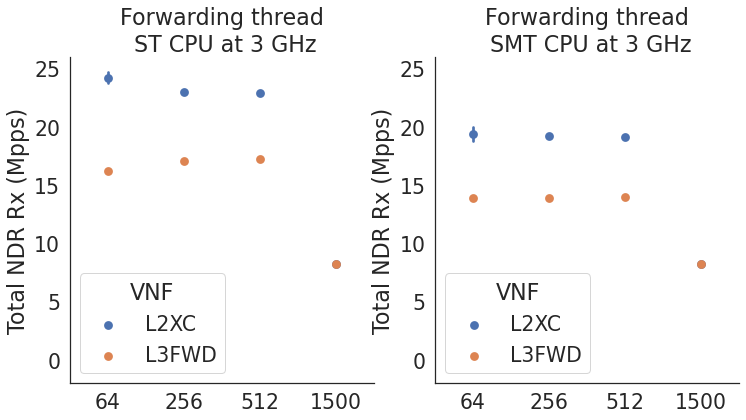

In [9]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[2*FIGSIZE[0], FIGSIZE[1]])

p_df = single_df
# p_df = p_df[p_df['packet_size'] == 64]

fig1 = sns.pointplot(
    data=p_df[p_df['ST'] == 'ST'],
    x="packet_size",
    y=p_df["total_rx_pps"] / (10**6),
    units="units",
    hue='VNF',
    ax=ax1,
    # palette = 'colorblind',
    ci='sd',
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    hue_order = ["L2XC", "L3FWD"],
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Total NDR Rx (Mpps)",
    xlabel="",
    ylim=[-2, 26],
    title = 'Forwarding thread\n ST CPU at 3 GHz'
)
plt.setp(fig.lines, linewidth=1.25)
ax1.legend(title='VNF', loc='lower left')

sns.despine()

fig2 = sns.pointplot(
    data=p_df[p_df['ST'] == 'SMT'],
    x="packet_size",
    y=p_df["total_rx_pps"] / (10**6),
    units="units",
    hue='VNF',
    ax=ax2,
    # palette = 'colorblind',
    ci='sd',
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    hue_order = ["L2XC", "L3FWD"],
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="Total NDR Rx (Mpps)",
    xlabel="",
    ylim=[-2, 26],
    title = 'Forwarding thread\n SMT CPU at 3 GHz'
)
plt.setp(fig.lines, linewidth=1.25)
ax2.legend(title='VNF', loc='lower left')

sns.despine()

# fig.savefig("../output_figures/ndr_bypass_single_instance_single_thread.pdf")

# HQoS Baseline

## Effect of packet classifier

In [11]:
measurements = list()
experiment_labels = [
    'ndr-hqos_disabled',
    'ndr-hqos_bypass',
]

for experiment in experiment_labels:
    
    output_dir = f"../output/{experiment}"
    
    for direc, sub_direc, files in os.walk(output_dir):
        if "discarded" in direc:
            continue

        if files == []:
            continue

        if "old" in direc:
            continue

        t = dict()
        misses = 0
        drops = 0
        vectors = 0
        calls = 0
        no_buf = 0
        vector_rate = 0.0
        nworkers = 0
        
        for file in files:
            none, label, packet_size, repeat = direc.replace(output_dir, "").split("/")
            
            if "average" in file:
                perfstat = pd.read_csv(direc + "/" + file, index_col = 'metrics')

            if "vpp" in file:
                with open(direc + "/" + file, "r", encoding="utf8", errors="ignore") as f:
                    for line in f.readlines():
                        p = line.strip().split()
                        if (
                            "/interfaces/dev0/rx-miss" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            misses = int(p[3])

                        if (
                            "/interfaces/dev0/rx-no-buf" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            no_buf = int(p[3])

                        if "/err/dev1-tx/Tx" in p and "2]:" in p[2] and "[0" in p[0]:
                            drops = int(p[3])

                        if (
                            "/nodes/dev1-output/vectors" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            vectors = int(p[3])

                        if "/sys/vector_rate" in p:
                            vector_rate = float(p[0])
                        
                        if "/sys/num_worker_threads" in p:
                            nworkers = float(p[0])

                        if (
                            "/nodes/dev1-output/calls" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            calls = int(p[3])

            if "trex" in file:
                with open(direc + "/" + file, "r") as f:
                    contents = f.read().replace("\n", "").replace("'", '"')
                    try:
                        t = json.loads(contents)
                    except SyntaxError:
                        print(direc + "/" + files[0])
                        continue
        
        metric= 'avg'
        total_errors = misses + drops + no_buf
        measurements.append(
            {
                "total_rx_L1": t["results"]["total_tx_L1"],
                "total_tx_L1": int(t["results"]["total_rx_L1"]),
                "total_tx_pps": int(t["results"]["tx_pps"]),
                "total_rx_pps": int(t["results"]["rx_pps"]),
                #"VNF": label,
                'disabled': 'disabled' if 'disabled' in experiment else 'bypass',
                #'nworkers': nworkers,
                "packet_size": int(packet_size),
                "misses": misses,
                "drops": drops,
                "misses_normalized": misses
                / (1 if total_errors == 0 else total_errors)
                * 100,
                "drops_normalized": drops
                / (1 if total_errors == 0 else total_errors)
                * 100,
                "no_buf": no_buf,
                "total_errors": total_errors,
                "units": repeat,
                "vectors": vectors,
                "vector_rate": vector_rate,
                "call": calls,
                
                'IPC': perfstat.loc['metric_kernel_CPI', metric],
                'Frontend Bound': perfstat.loc['metric_TMA_Frontend_Bound(%)',metric],
                'Backend Bound': perfstat.loc['metric_TMA_Backend_Bound(%)', metric],
                'Cache Bound': perfstat.loc['metric_TMA_..Memory_Bound(%)', metric],
                'Core Bound': perfstat.loc['metric_TMA_..Core_Bound(%)', metric],
                'Memory Bound': perfstat.loc['metric_TMA_....MEM_Bound(%)', metric],
                'DTLB load miss': perfstat.loc['metric_DTLB load miss latency (in core clks)', metric],
                
                'L1 Bound': perfstat.loc['metric_TMA_....L1_Bound(%)', metric],
                'L2 Bound': perfstat.loc['metric_TMA_....L2_Bound(%)', metric],
                'L3 Bound': perfstat.loc['metric_TMA_....L3_Bound(%)',metric],

            }
        )
bypass_df = pd.DataFrame(measurements)


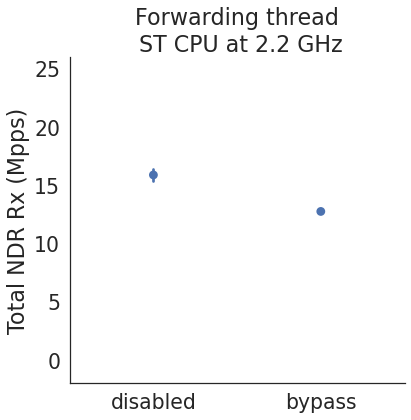

In [12]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=FIGSIZE)

p_df = bypass_df
# p_df = p_df[p_df['packet_size'] == 64]

fig1 = sns.pointplot(
    data=p_df,
    x="disabled",
    y=p_df["total_rx_pps"] / (10**6),
    units="units",
    #hue='VNF',
    ax=ax1,
    # palette = 'colorblind',
    ci='sd',
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    #hue_order = ["L2XC", "L3FWD"],
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Total NDR Rx (Mpps)",
    xlabel="",
    ylim=[-2, 26],
    title = 'Forwarding thread\n ST CPU at 2.2 GHz'
)
plt.setp(fig.lines, linewidth=1.25)
#ax1.legend(title='VNF', loc='lower left')
sns.despine()


## Multicore scaling

In [32]:
measurements = list()

experiment_labels = [
    'ndr-bypass-2worker-2200',
    'ndr-bypass-2worker-2200-ht',
    'ndr-bypass-4worker-2200',
    'ndr-bypass-4worker-2200-ht',
    'ndr-bypass-6worker-2200',
    'ndr-bypass-6worker-2200-ht',
    'ndr-bypass-8worker-2200',
    'ndr-bypass-8worker-2200-ht',
    'ndr-bypass-10worker-2200',
    'ndr-bypass-10worker-2200-ht',
    'ndr-bypass-12worker-2200-ht',
]

for experiment in experiment_labels:
    
    output_dir = f"../output/{experiment}"
    
    for direc, sub_direc, files in os.walk(output_dir):
        if "discarded" in direc:
            continue

        if files == []:
            continue

        if "old" in direc:
            continue

        t = dict()
        misses = 0
        drops = 0
        vectors = 0
        calls = 0
        no_buf = 0
        vector_rate = 0.0
        nworkers = 0
        
        for file in files:
            none, label, packet_size, repeat = direc.replace(output_dir, "").split("/")
            
            if "average" in file:
                perfstat = pd.read_csv(direc + "/" + file, index_col = 'metrics')

            if "vpp" in file:
                with open(direc + "/" + file, "r", encoding="utf8", errors="ignore") as f:
                    for line in f.readlines():
                        p = line.strip().split()
                        if (
                            "/interfaces/dev0/rx-miss" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            misses = int(p[3])

                        if (
                            "/interfaces/dev0/rx-no-buf" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            no_buf = int(p[3])

                        if "/err/dev1-tx/Tx" in p and "2]:" in p[2] and "[0" in p[0]:
                            drops = int(p[3])

                        if (
                            "/nodes/dev1-output/vectors" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            vectors = int(p[3])

                        if "/sys/vector_rate" in p:
                            vector_rate = float(p[0])
                        
                        if "/sys/num_worker_threads" in p:
                            nworkers = float(p[0])

                        if (
                            "/nodes/dev1-output/calls" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            calls = int(p[3])

            if "trex" in file:
                with open(direc + "/" + file, "r") as f:
                    contents = f.read().replace("\n", "").replace("'", '"')
                    try:
                        t = json.loads(contents)
                    except SyntaxError:
                        print(direc + "/" + files[0])
                        continue
        
        metric= 'avg'
        total_errors = misses + drops + no_buf
        measurements.append(
            {
                "total_rx_L1": t["results"]["total_tx_L1"],
                "total_tx_L1": int(t["results"]["total_rx_L1"]),
                "total_tx_pps": int(t["results"]["tx_pps"]),
                "total_rx_pps": int(t["results"]["rx_pps"]),
                "VNF": label,
                'disabled': 'disabled' if 'disabled' in experiment else 'bypass',
                'nworkers': nworkers,
                'ST': 'SMT' if 'ht' in experiment else 'ST',
                "packet_size": int(packet_size),
                "misses": misses,
                "drops": drops,
                "misses_normalized": misses
                / (1 if total_errors == 0 else total_errors)
                * 100,
                "drops_normalized": drops
                / (1 if total_errors == 0 else total_errors)
                * 100,
                "no_buf": no_buf,
                "total_errors": total_errors,
                "units": repeat,
                "vectors": vectors,
                "vector_rate": vector_rate,
                "call": calls,
                
                'IPC': perfstat.loc['metric_kernel_CPI', metric],
                'Frontend Bound': perfstat.loc['metric_TMA_Frontend_Bound(%)',metric],
                'Backend Bound': perfstat.loc['metric_TMA_Backend_Bound(%)', metric],
                'Cache Bound': perfstat.loc['metric_TMA_..Memory_Bound(%)', metric],
                'Core Bound': perfstat.loc['metric_TMA_..Core_Bound(%)', metric],
                'Memory Bound': perfstat.loc['metric_TMA_....MEM_Bound(%)', metric],
                'DTLB load miss': perfstat.loc['metric_DTLB load miss latency (in core clks)', metric],
                
                'L1 Bound': perfstat.loc['metric_TMA_....L1_Bound(%)', metric],
                'L2 Bound': perfstat.loc['metric_TMA_....L2_Bound(%)', metric],
                'L3 Bound': perfstat.loc['metric_TMA_....L3_Bound(%)',metric],

            }
        )
multicore_df = pd.DataFrame(measurements)


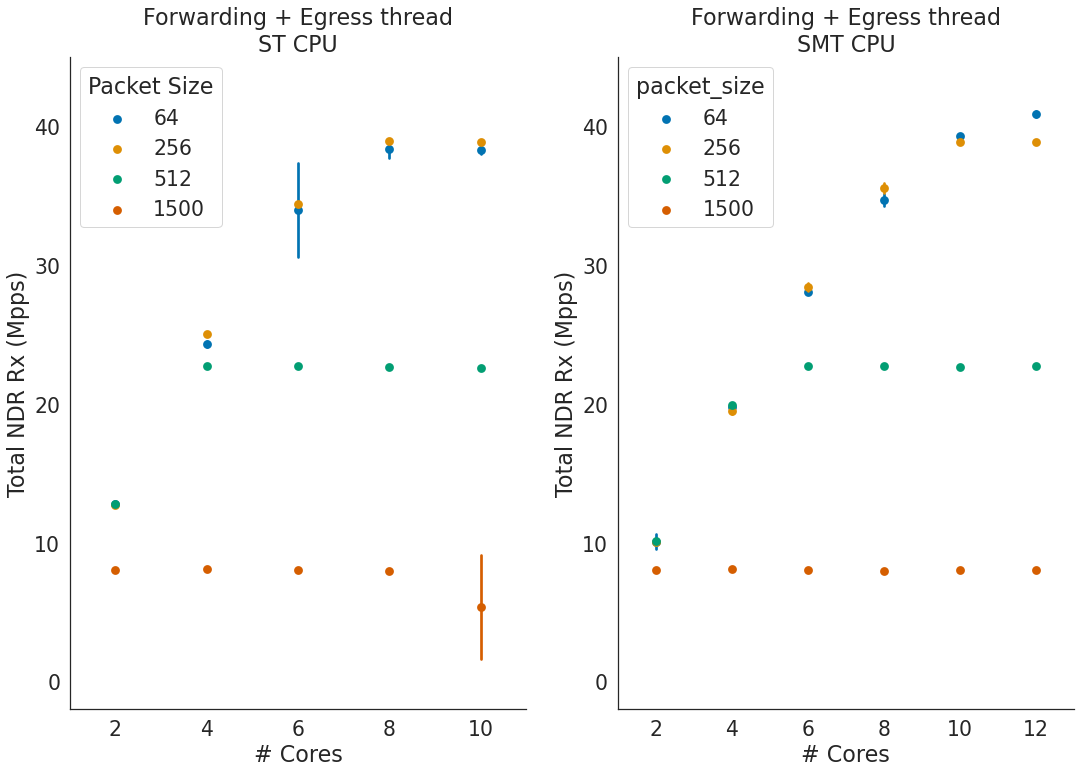

In [33]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[3*FIGSIZE[0], 2*FIGSIZE[1]])

p_df = multicore_df[multicore_df['ST'] == 'ST']
p_df = p_df[p_df['VNF'] == 'L2XC']
p_df = p_df.astype({'nworkers': int}).loc[p_df['nworkers'].isin([2,4,6,8,10,12])]

fig1 = sns.pointplot(
    data=p_df,
    x="nworkers",
    y=p_df["total_rx_pps"] / (10**6),
    units="units",
    hue='packet_size',
    ax=ax1,
    palette = 'colorblind',
    ci='sd',
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    label="Measured",
    #hue_order = [2, 4],
)

ax1.set(
    ylabel="Total NDR Rx (Mpps)",
    xlabel="# Cores",
    ylim=[-2, 45],
    title = 'Forwarding + Egress thread\nST CPU'
)
plt.setp(fig.lines, linewidth=1.25)
ax1.legend(title='Packet Size', loc='upper left')


sns.despine()

p_df = multicore_df[multicore_df['ST'] == 'SMT']
p_df = p_df[p_df['VNF'] == 'L2XC']
p_df = p_df.astype({'nworkers': int}).loc[p_df['nworkers'].isin([2,4,6,8,10,12])]

fig2 = sns.pointplot(
    data=p_df,
    x="nworkers",
    y=p_df["total_rx_pps"] / (10**6),
    units="units",
    hue='packet_size',
    ax=ax2,
    palette = 'colorblind',
    ci='sd',
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    label="Measured",
    #hue_order = [2, 4],
)

ax2.set(
    ylabel="Total NDR Rx (Mpps)",
    xlabel="# Cores",
    ylim=[-2, 45],
    title = 'Forwarding + Egress thread\nSMT CPU'
)
plt.setp(fig.lines, linewidth=1.25)
ax1.legend(title='Packet Size', loc='upper left')


sns.despine()

# fig.savefig("../output_figures/ndr_bypass_single_instance_single_thread.pdf")


## HQoS configs

### HQoS @ Max

In [4]:
measurements = list()
experiment_labels = [
    '1flow',
    '2flow',
    '4flow',
    '8flow',
]

for experiment in experiment_labels:
    output_dir = f"../output/hqos_max-ndr-{experiment}"
    for direc, sub_direc, files in os.walk(output_dir):
        if "discarded" in direc:
            continue

        if files == []:
            continue

        if "old" in direc:
            continue

        t = dict()
        misses = 0
        drops = 0
        vectors = 0
        call = 0

        for file in files:
            none, flows, packet_size, repeat = direc.replace(output_dir, "").split("/")

            if "average" in file:
                perfstat = pd.read_csv(direc + "/" + file, index_col = 'metrics')

            if "vpp" in file:
                with open(
                    direc + "/" + file, "r", encoding="utf8", errors="ignore"
                ) as f:
                    for line in f.readlines():
                        p = line.strip().split()
                        if (
                            "/interfaces/dev0/rx-miss" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            misses = int(p[3])
                            continue

                        m = re.search(r"\[0 @ 2\]: (\d*) packets \/err\/dev1-tx\/Tx packet drops.*", line)
                        if (m):
                            drops += int(m.group(1))
                            continue

                        if (
                            "/nodes/dev0-output/vectors" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            vectors = int(p[3])
                            continue

                        if (
                            "/nodes/dev0-output/calls" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            calls = int(p[3])
                            continue

            if "trex" in file:
                with open(direc + "/" + file, "r") as f:
                    contents = f.read().replace("\n", "").replace("'", '"')
                    try:
                        t = json.loads(contents)
                    except SyntaxError:
                        print(direc + "/" + files[0])
                        continue


        metric = 'avg'
        total_errors = misses + drops
        measurements.append(
            {
                "total_rx_L1": t["results"]["total_tx_L1"],
                "total_tx_L1": int(t["results"]["total_rx_L1"]),
                "total_tx_pps": int(t["results"]["tx_pps"]),
                "total_rx_pps": int(t["results"]["rx_pps"]),
                #"VNF": label,
                #'ST': 'SMT' if 'ht' in experiment else 'ST',
                'ntc': experiment,
                "packet_size": int(packet_size),
                "misses": misses,
                'flows': int(flows),
                "drops": drops,
                "misses_normalized": misses
                / (1 if total_errors == 0 else total_errors)
                * 100,
                "drops_normalized": drops
                / (1 if total_errors == 0 else total_errors)
                * 100,
                #"no_buf": no_buf,
                "total_errors": total_errors,
                "units": repeat,
                "vectors": vectors,

                'IPC': perfstat.loc['metric_kernel_CPI', metric],
                'Frontend Bound': perfstat.loc['metric_TMA_Frontend_Bound(%)',metric],
                'Backend Bound': perfstat.loc['metric_TMA_Backend_Bound(%)', metric],
                'Cache Bound': perfstat.loc['metric_TMA_..Memory_Bound(%)', metric],
                'Core Bound': perfstat.loc['metric_TMA_..Core_Bound(%)', metric],
                'Memory Bound': perfstat.loc['metric_TMA_....MEM_Bound(%)', metric],
                'DTLB load miss': perfstat.loc['metric_DTLB load miss latency (in core clks)', metric],
                'Bad Speculation': perfstat.loc['metric_TMA_Bad_Speculation(%)', metric],
                'Retiring': perfstat.loc['metric_TMA_Retiring(%)', metric],

                'L1 Bound': perfstat.loc['metric_TMA_....L1_Bound(%)', metric],
                'L2 Bound': perfstat.loc['metric_TMA_....L2_Bound(%)', metric],
                'L3 Bound': perfstat.loc['metric_TMA_....L3_Bound(%)',metric],

              #"vector_rate": vector_rate,
                #"call": calls,
            }
        )
        hqosmax_df = pd.DataFrame(measurements)

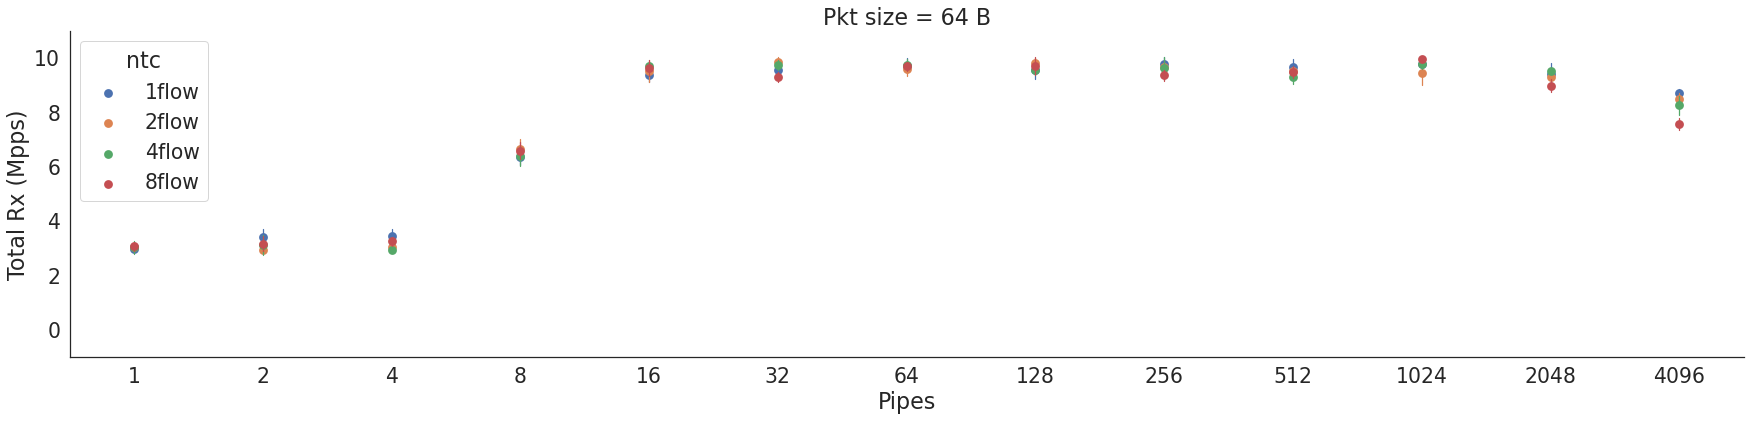

In [5]:
# %#matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[5 * FIGSIZE[0], FIGSIZE[1]])

p_df = hqosmax_df
p_df = p_df.astype({"flows": int})

# ax1.set_xscale('symlog')

fig = sns.pointplot(
    data=p_df[p_df["packet_size"] == 64],
    x="flows",
    y=hqosmax_df["total_rx_pps"] / (10**6),
    hue = 'ntc',
    # y=multicore_measures_df["total_rx_L1"] / (10**9),
    # units="units",
    # estimator = pd.mean,
    # ax=ax1,
    # palette="colorblind",
    ci="sd",
    err_style="bars",
    # markersize=1,
    # errorwidth=3,
    join=False,
    linestyle="--",
    # linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Total Rx (Mpps)",
    xlabel="Pipes",
    title="Pkt size = 64 B",
    ylim=[-1, 11],
)
plt.setp(fig.lines, linewidth=1.25)
sns.despine()

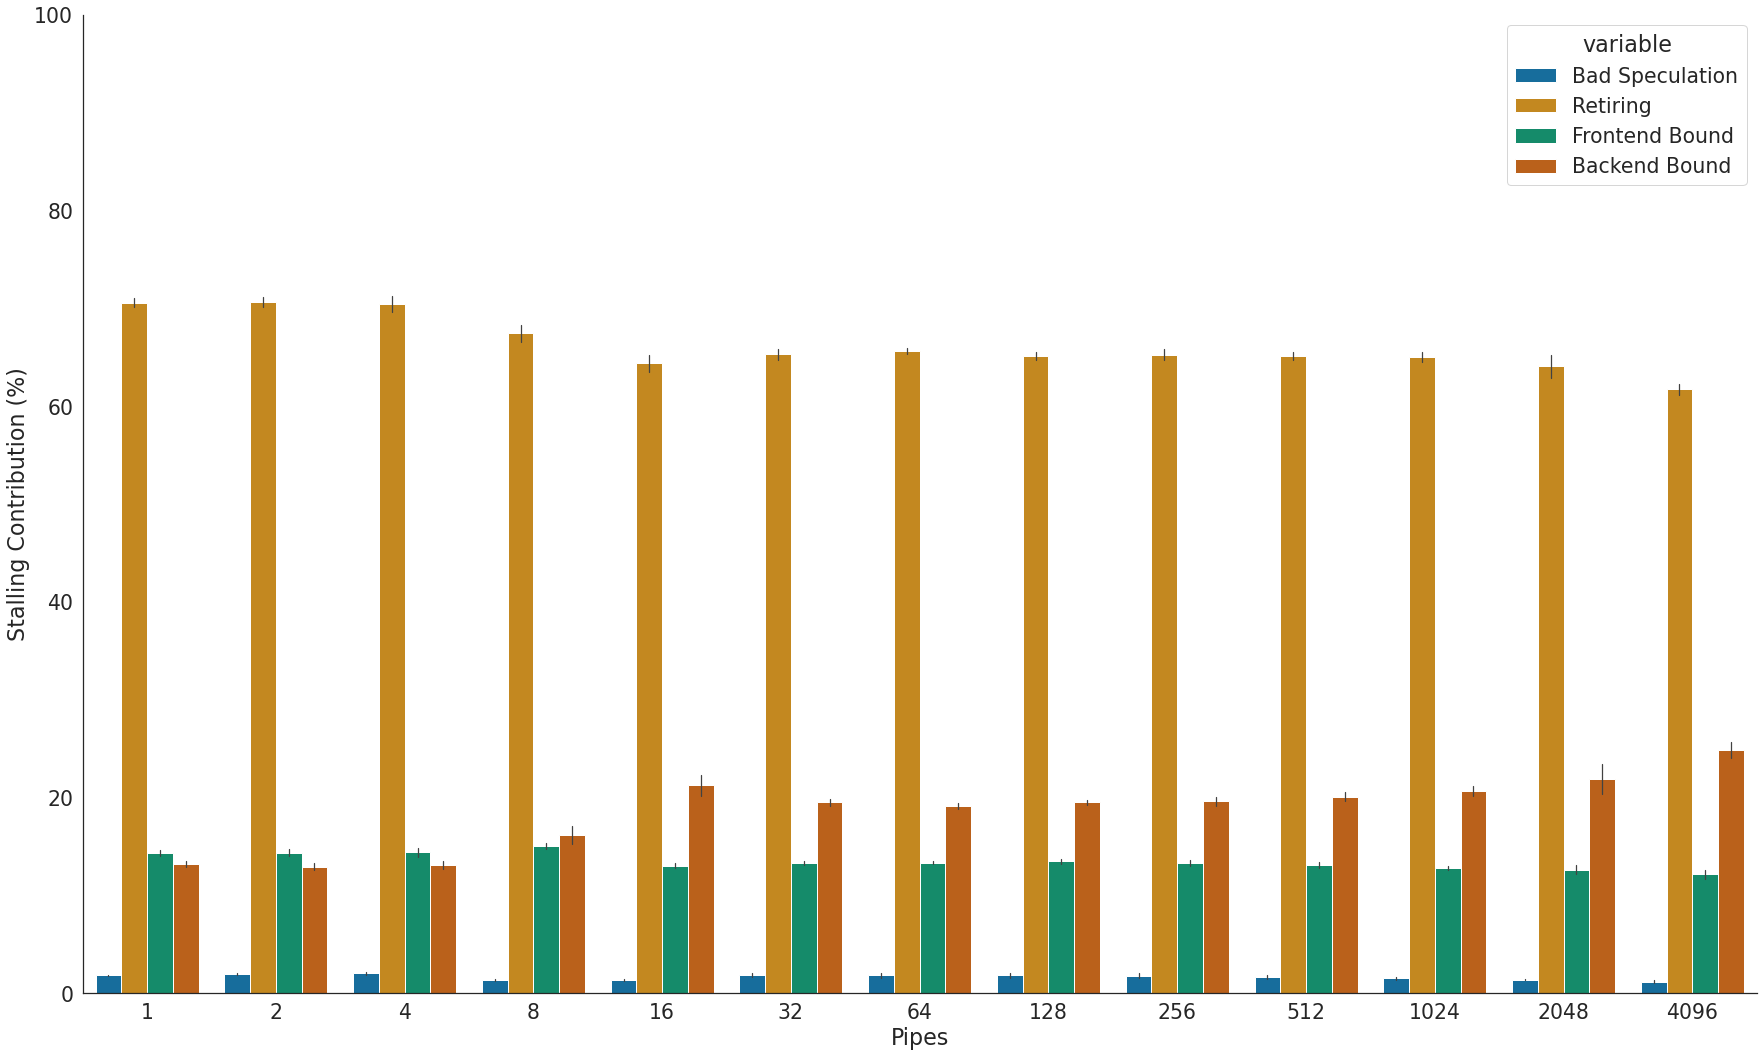

In [6]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[5*FIGSIZE[0], 3*FIGSIZE[1]])

PKT_SIZE = 64

p_df = pd.melt(
    hqosmax_df,
    id_vars = ['flows', 'units'],
    value_vars = ['Bad Speculation', 'Retiring', 'Frontend Bound', 'Backend Bound']
)

#ax1.set_xscale('symlog')
fig = sns.barplot(
    data=p_df,
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax1,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Stalling Contribution (%)",
    xlabel="Pipes",
   # title="Misses\nPkt size = 64 B",
    ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

sns.despine()

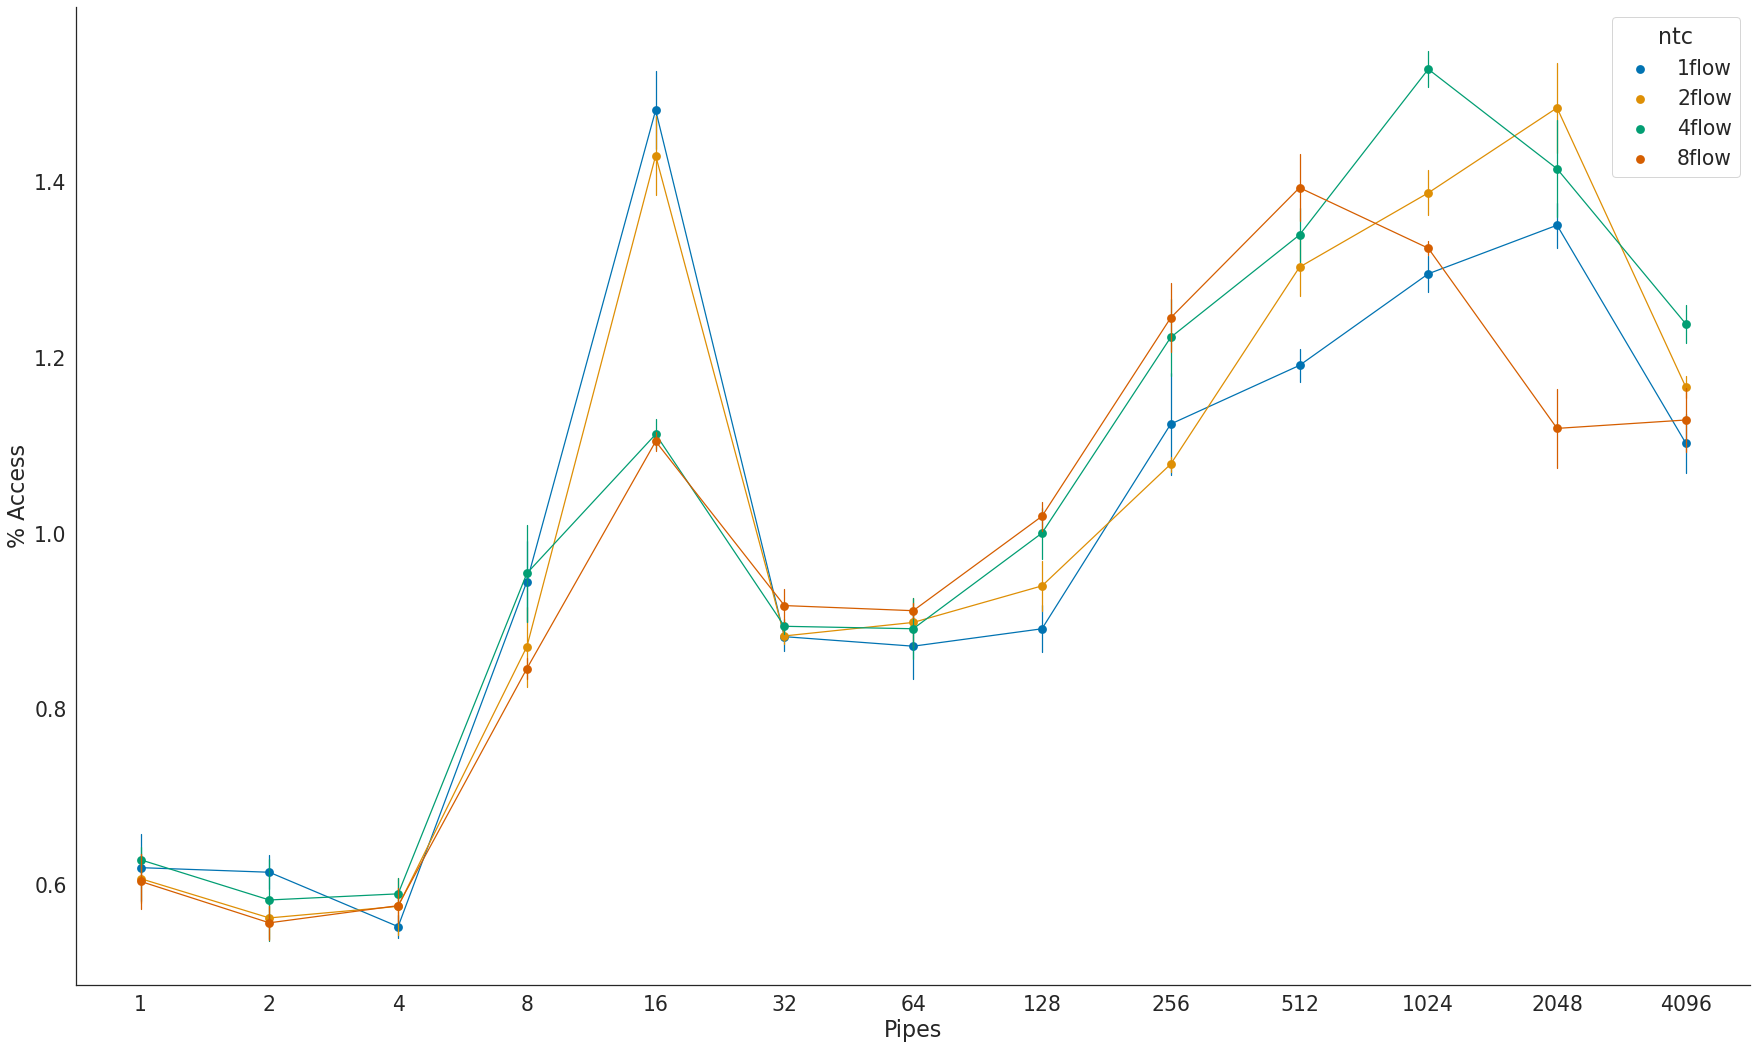

In [12]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[5*FIGSIZE[0], 3*FIGSIZE[1]])

PKT_SIZE = 64

p_df = pd.melt(
    hqosmax_df,
    id_vars = ['flows', 'units', 'ntc'],
    # value_vars = ['L1 Bound','L2 Bound','L3 Bound','Memory Bound']
    value_vars = ['L3 Bound']
)

#ax1.set_xscale('symlog')
fig = sns.pointplot(
    data=p_df,
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="ntc",
    units="units",
    #estimator = None,
    ax=ax1,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=True,
    linestyle="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="% Access",
    xlabel="Pipes",
   # title="Misses\nPkt size = 64 B",
   # ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

sns.despine()

In [92]:
p_df

,flows,units,ntc,variable,value
0,1024,3,1flow,L3 Bound,1.266901
1,1024,1,1flow,L3 Bound,1.312530
2,1024,2,1flow,L3 Bound,1.306536
3,4,3,1flow,L3 Bound,0.568783
4,4,1,1flow,L3 Bound,0.537959
...,...,...,...,...,...
307,64,1,8flow,Memory Bound,0.232676
308,64,2,8flow,Memory Bound,0.228872
309,2,3,8flow,Memory Bound,0.118954
310,2,1,8flow,Memory Bound,0.128728


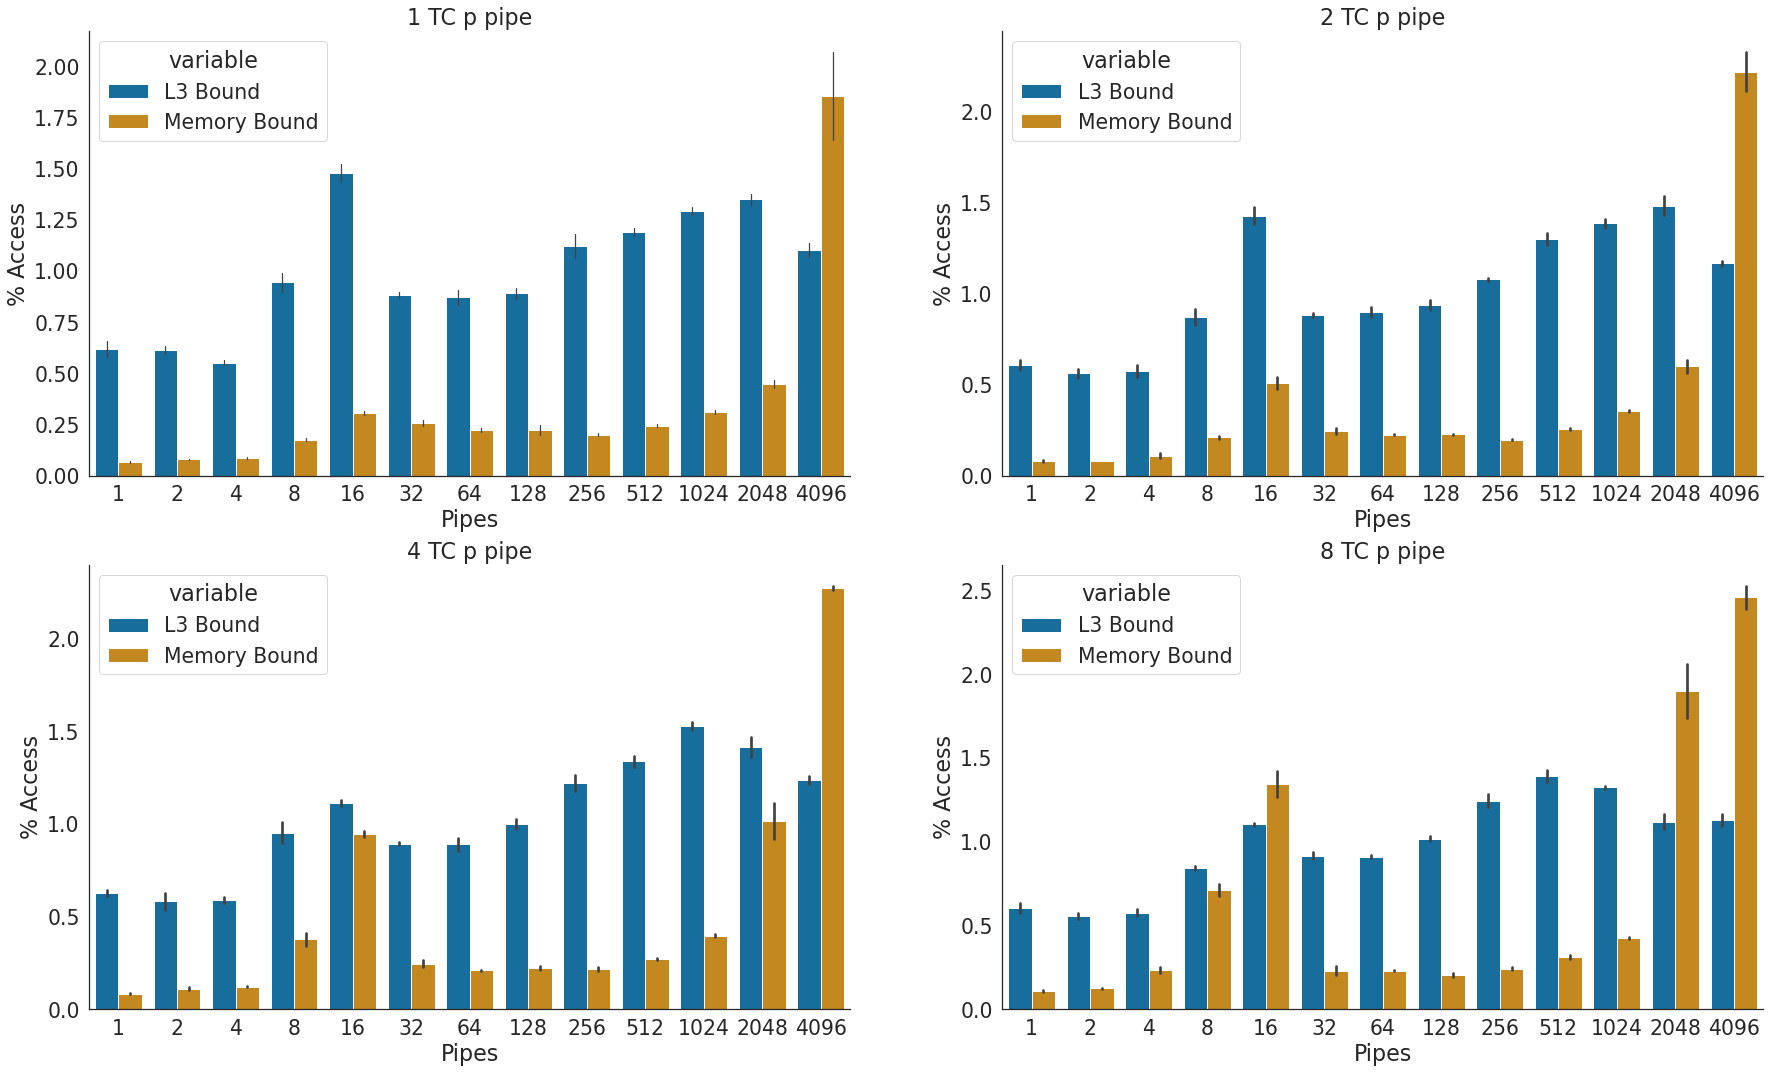

In [94]:
%matplotlib inline
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=[5*FIGSIZE[0], 3*FIGSIZE[1]])

PKT_SIZE = 64

p_df = pd.melt(
    hqosmax_df,
    id_vars = ['flows', 'units', 'ntc'],
    value_vars = ['L3 Bound','Memory Bound']
)

#ax1.set_xscale('symlog')
fig = sns.barplot(
    data=p_df[p_df['ntc'] == '1flow'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax1,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="1 TC p pipe",
    #ylim= [0,50],
)
plt.setp(fig.lines, linewidth=1.25)

#ax1.set_xscale('symlog')
fig2 = sns.barplot(
    data=p_df[p_df['ntc'] == '2flow'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax2,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="2 TC p pipe",
    #ylim= [0,50],
)
plt.setp(fig.lines, linewidth=1.25)

#ax1.set_xscale('symlog')
fig3 = sns.barplot(
    data=p_df[p_df['ntc'] == '4flow'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax3,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax3.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="4 TC p pipe",
   # ylim= [0,50],
)
plt.setp(fig.lines, linewidth=1.25)


#ax1.set_xscale('symlog')
fig4 = sns.barplot(
    data=p_df[p_df['ntc'] == '8flow'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax4,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax4.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="8 TC p pipe",
    #ylim= [0,50],
)
plt.setp(fig.lines, linewidth=1.25)


sns.despine()

### HQoS @ 6.1 Mbps

In [78]:
measurements = list()
experiment_list = [
    "1flows-shaper",
    "2flow-shaper", 
    "4flows-shaper", 
    "8flows-shaper", 
]

for experiment in experiment_list:
    output_dir = f"../output/6.1-{experiment}"
    for direc, sub_direc, files in os.walk(output_dir):
        if "discarded" in direc:
            continue

        if files == []:
            continue

        if "old" in direc:
            continue

        t = dict()
        misses = 0
        drops = 0
        vectors = 0
        call = 0
        loops_p_worker = 0

        for file in files:
            none, flows, packet_size, repeat = direc.replace(output_dir, "").split("/")

            if "average" in file:
                perfstat = pd.read_csv(direc + "/" + file, index_col = 'metrics')

            if "vpp" in file:
                with open(
                    direc + "/" + file, "r", encoding="utf8", errors="ignore"
                ) as f:
                    for line in f.readlines():
                        p = line.strip().split()
                        if (
                            "/interfaces/dev0/rx-miss" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            misses = int(p[3])
                            continue

                        m = re.search(r"\[0 @ 2\]: (\d*) packets \/err\/dev1-tx\/Tx packet drops.*", line)
                        if (m):
                            drops += int(m.group(1))
                            continue

                        if (
                            "/sys/vector_rate_per_worker" in line
                            and "0]:" in p[2]
                            and "[2" in p[0]

                        ):
                            vectors = int(p[3])
                            continue

                        if (
                            " /sys/loops_per_worker" in line
                            and "0]:" in p[2]
                            and "[2" in p[0]
                        ):
                            loops_p_worker = int(p[3])
                            continue

            if "trex" in file:
                with open(direc + "/" + file, "r") as f:
                    contents = f.read().replace("\n", "").replace("'", '"')
                    try:
                        t = ast.literal_eval(contents)
                    except SyntaxError:
                        print(direc + "/" + files[0])
                        continue


        metric = 'max'
        total_errors = misses + drops
        pkt_loss = t["total"]["opackets"] - t["total"]["ipackets"]

        measurements.append(
            {
                "total_rx_L1": t["total"]["rx_bps_L1"],
                "total_tx_L1": int(t["total"]["tx_bps_L1"]),
                "total_tx_pps": int(t["total"]["tx_pps"]),
                "total_rx_pps": int(t["total"]["rx_pps"]),
                "lost_packets": pkt_loss,

                #"VNF": label,
                #'ST': 'SMT' if 'ht' in experiment else 'ST',
                'ntc': experiment.strip('flow-shaper'),
                "packet_size": int(packet_size),
                "misses": misses,
                'flows': int(flows),
                "drops": drops,
                "misses_normalized": misses
                / (1 if total_errors == 0 else total_errors)
                * 100,
                "drops_normalized": drops
                / (1 if total_errors == 0 else total_errors)
                * 100,
                #"no_buf": no_buf,
                "total_errors": total_errors,
                "units": repeat,
                "vectors": vectors,
                "loops": loops_p_worker,

                'IPC': perfstat.loc['metric_IPC', metric],
                'CPI': perfstat.loc['metric_CPI', metric],
                'Frontend Bound': perfstat.loc['metric_TMA_Frontend_Bound(%)',metric],
                'Backend Bound': perfstat.loc['metric_TMA_Backend_Bound(%)', metric],
                'Memory Bound': perfstat.loc['metric_TMA_..Memory_Bound(%)', metric],
                'Core Bound': perfstat.loc['metric_TMA_..Core_Bound(%)', metric],
                'External Memory Bound': perfstat.loc['metric_TMA_....MEM_Bound(%)', metric],
                'DTLB load miss': perfstat.loc['metric_DTLB load miss latency (in core clks)', metric],
                'Bad Speculation': perfstat.loc['metric_TMA_Bad_Speculation(%)', metric],
                'Retiring': perfstat.loc['metric_TMA_Retiring(%)', metric],

                'Ports Utilization': perfstat.loc['metric_TMA_......Ports_Utilized_3m(%)', metric],

                'L1 Bound': perfstat.loc['metric_TMA_....L1_Bound(%)', metric],
                'L2 Bound': perfstat.loc['metric_TMA_....L2_Bound(%)', metric],
                'L3 Bound': perfstat.loc['metric_TMA_....L3_Bound(%)',metric],

              #"vector_rate": vector_rate,
            }
        )
        shape_61_df = pd.DataFrame(measurements)

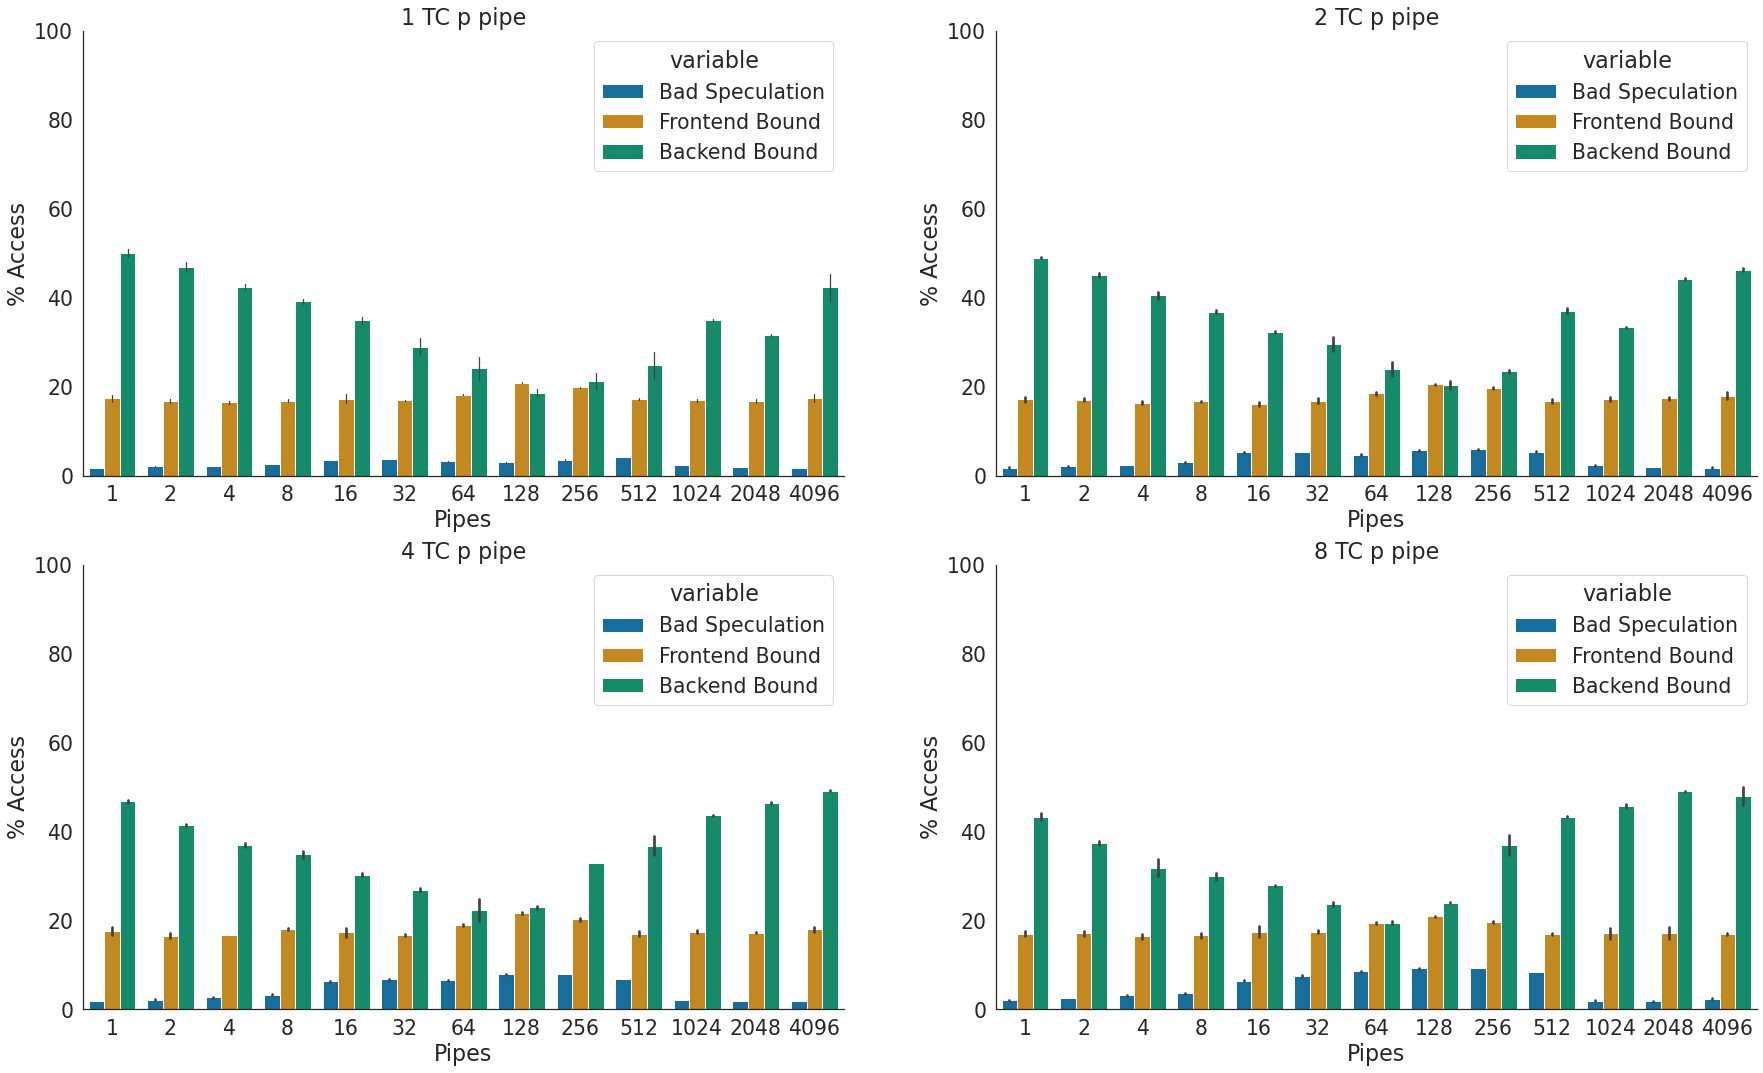

In [75]:
%matplotlib inline
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=[5*FIGSIZE[0], 3*FIGSIZE[1]])

PKT_SIZE = 64

p_df = pd.melt(
    shape_61_df,
    id_vars = ['flows', 'units', 'ntc'],
    value_vars = ['Bad Speculation', 'Frontend Bound', 'Backend Bound']
)

#ax1.set_xscale('symlog')
fig = sns.barplot(
    data=p_df[p_df['ntc'] == '1'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax1,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="1 TC p pipe",
    ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

#ax1.set_xscale('symlog')
fig2 = sns.barplot(
    data=p_df[p_df['ntc'] == '2'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax2,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="2 TC p pipe",
    ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

#ax1.set_xscale('symlog')
fig3 = sns.barplot(
    data=p_df[p_df['ntc'] == '4'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax3,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax3.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="4 TC p pipe",
    ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)


#ax1.set_xscale('symlog')
fig4 = sns.barplot(
    data=p_df[p_df['ntc'] == '8'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax4,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax4.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="8 TC p pipe",
    ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)


sns.despine()

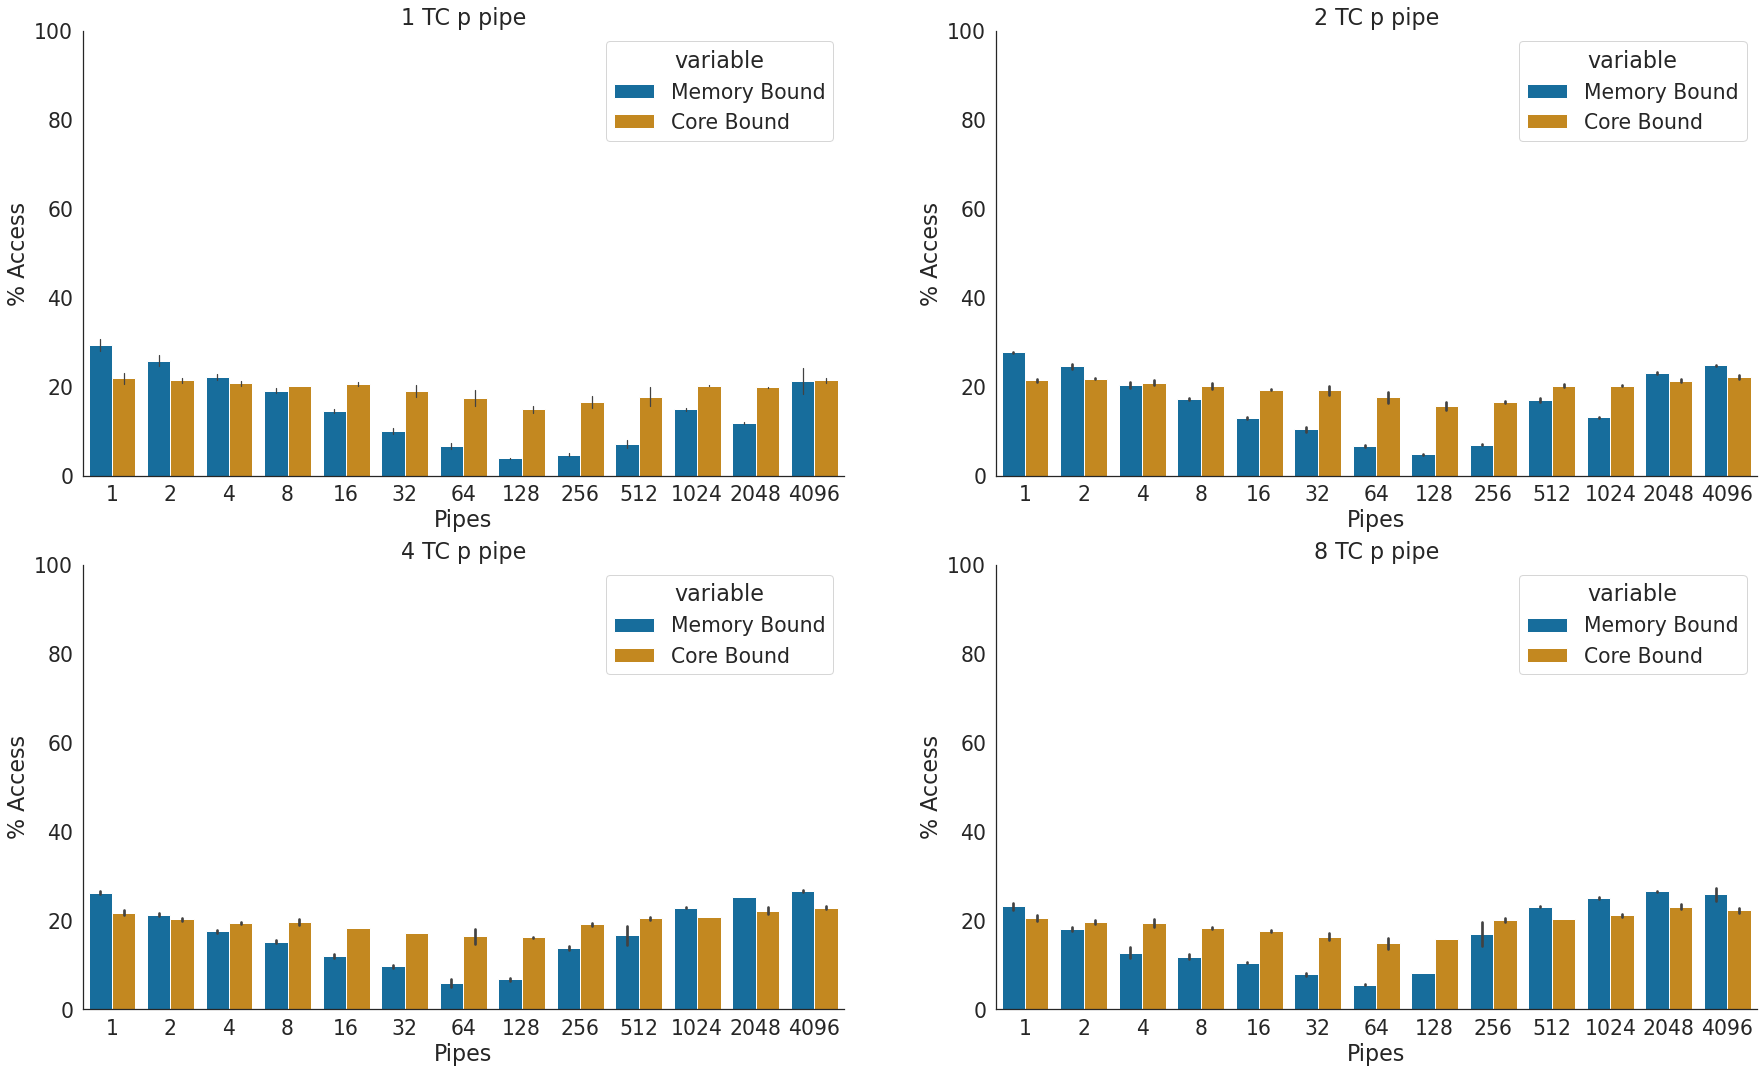

In [80]:
%matplotlib inline
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=[5*FIGSIZE[0], 3*FIGSIZE[1]])

PKT_SIZE = 64

p_df = pd.melt(
    shape_61_df,
    id_vars = ['flows', 'units', 'ntc'],
    value_vars = ['Memory Bound', 'Core Bound']
)

#ax1.set_xscale('symlog')
fig = sns.barplot(
    data=p_df[p_df['ntc'] == '1'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax1,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="1 TC p pipe",
    ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

#ax1.set_xscale('symlog')
fig2 = sns.barplot(
    data=p_df[p_df['ntc'] == '2'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax2,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="2 TC p pipe",
    ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

#ax1.set_xscale('symlog')
fig3 = sns.barplot(
    data=p_df[p_df['ntc'] == '4'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax3,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax3.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="4 TC p pipe",
    ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)


#ax1.set_xscale('symlog')
fig4 = sns.barplot(
    data=p_df[p_df['ntc'] == '8'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax4,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax4.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="8 TC p pipe",
    ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)


sns.despine()

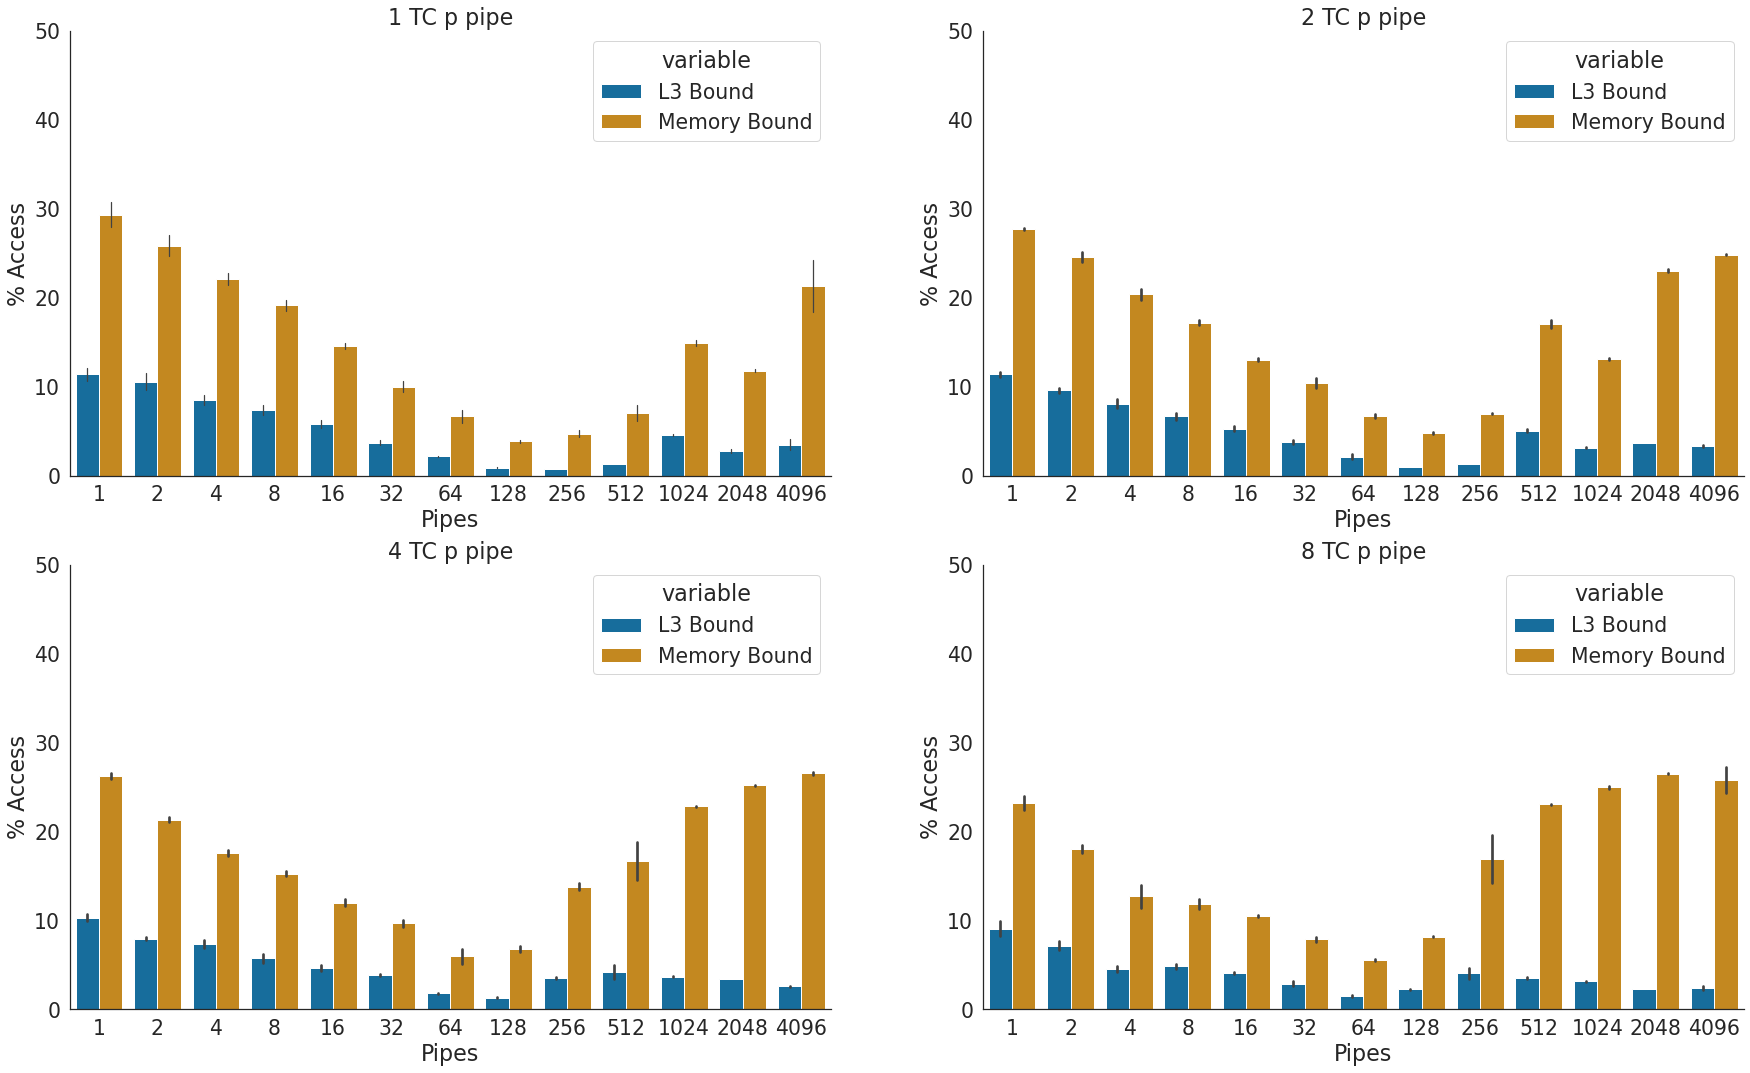

In [86]:
%matplotlib inline
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=[5*FIGSIZE[0], 3*FIGSIZE[1]])

PKT_SIZE = 64

p_df = pd.melt(
    shape_61_df,
    id_vars = ['flows', 'units', 'ntc'],
   # value_vars = ['L1 Bound','L2 Bound','L3 Bound','Memory Bound']
     value_vars = ['L3 Bound','Memory Bound']
)

#ax1.set_xscale('symlog')
fig = sns.barplot(
    data=p_df[p_df['ntc'] == '1'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax1,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="1 TC p pipe",
    ylim= [0,50],
)
plt.setp(fig.lines, linewidth=1.25)

#ax1.set_xscale('symlog')
fig2 = sns.barplot(
    data=p_df[p_df['ntc'] == '2'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax2,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="2 TC p pipe",
    ylim= [0,50],
)
plt.setp(fig.lines, linewidth=1.25)

#ax1.set_xscale('symlog')
fig3 = sns.barplot(
    data=p_df[p_df['ntc'] == '4'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax3,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax3.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="4 TC p pipe",
    ylim= [0,50],
)
plt.setp(fig.lines, linewidth=1.25)


#ax1.set_xscale('symlog')
fig4 = sns.barplot(
    data=p_df[p_df['ntc'] == '8'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax4,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax4.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="8 TC p pipe",
    ylim= [0,50],
)
plt.setp(fig.lines, linewidth=1.25)


sns.despine()

## HQoS @ 6.1

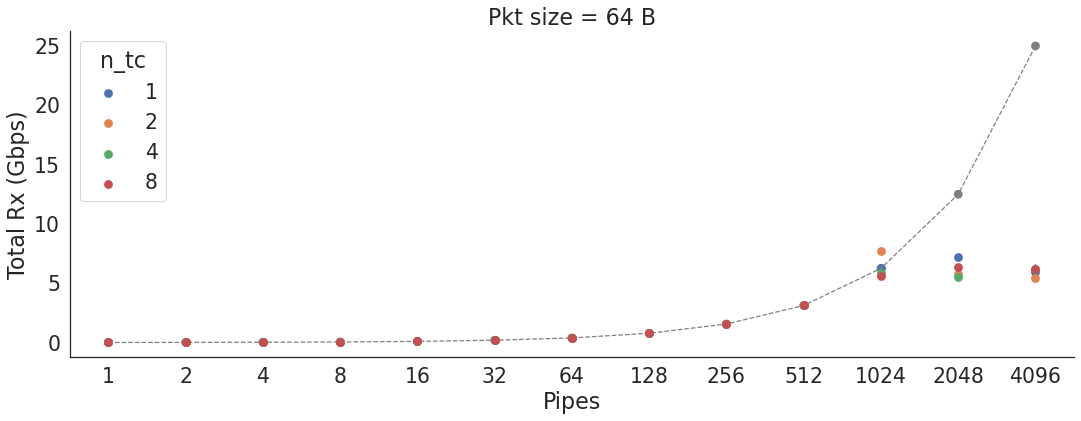

In [4]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[3*FIGSIZE[0], FIGSIZE[1]])

PKT_SIZE = 64

ideal_rate_df = pd.DataFrame([(i, 6.1*i) for i in set(shape_61_df['flows'])])

fig = sns.pointplot(
    data=ideal_rate_df,
    x=0,
    y = ideal_rate_df[1]/(10**3),
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    #estimator = None,
    ax=ax1,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=True,
    linestyle="--",
    linewidth=0.005,
    color = 'grey',
    linestyles="--",
    # hue_order = [64, 256, 512, 1500],
)


fig = sns.pointplot(
    data=shape_61_df,
    x="flows",
    y = shape_61_df['total_rx_L1']/(10**9),
    #y=shape_61_df["total_rx_pps"] / (10**6),
    hue="n_tc",
    units="units",
    #estimator = None,
    ax=ax1,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=False,
    linestyle="--",
    linewidth=0.005,
    
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Total Rx (Gbps)",
    xlabel="Pipes",
    title="Pkt size = 64 B",
)
plt.setp(fig.lines, linewidth=1.25)
sns.despine()

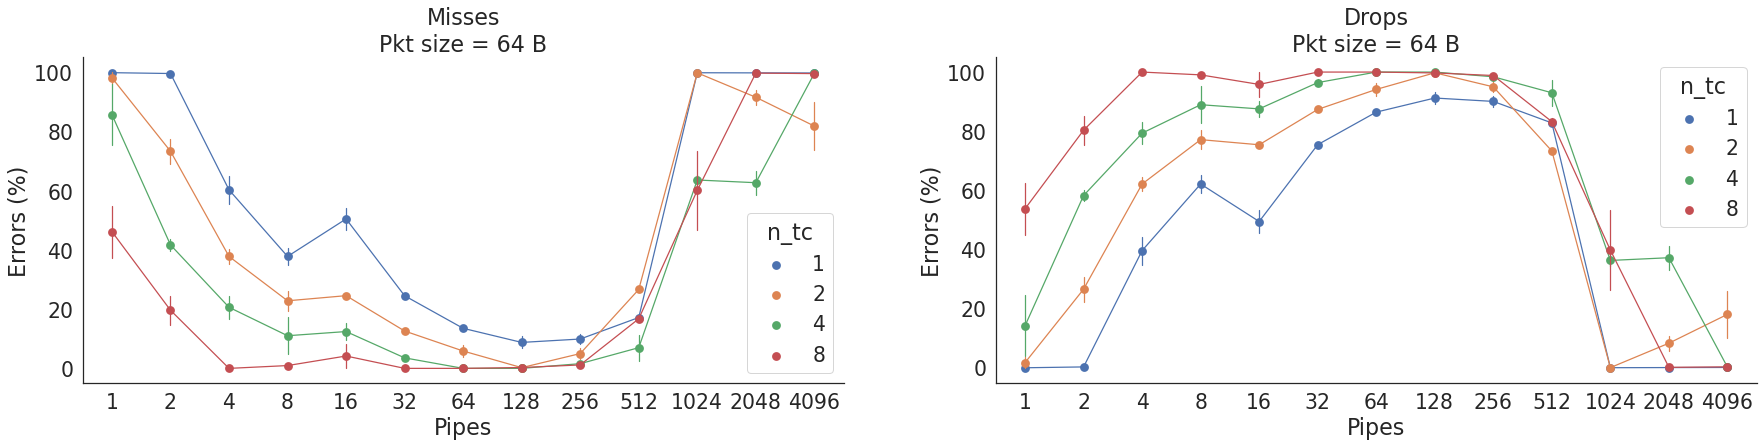

In [5]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[5*FIGSIZE[0], FIGSIZE[1]])

PKT_SIZE = 64

#ax1.set_xscale('symlog')

fig = sns.pointplot(
    data=shape_61_df,
    x="flows",
    y = 'misses_normalized',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="n_tc",
    units="units",
    #estimator = None,
    ax=ax1,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=True,
    linestyle="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Errors (%)",
    xlabel="Pipes",
    title="Misses\nPkt size = 64 B",
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=shape_61_df,
    x="flows",
    y = 'drops_normalized',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="n_tc",
    units="units",
    #estimator = None,
    ax=ax2,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=True,
    linestyle="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="Errors (%)",
    xlabel="Pipes",
    title="Drops\nPkt size = 64 B",
)
plt.setp(fig.lines, linewidth=1.25)


sns.despine()

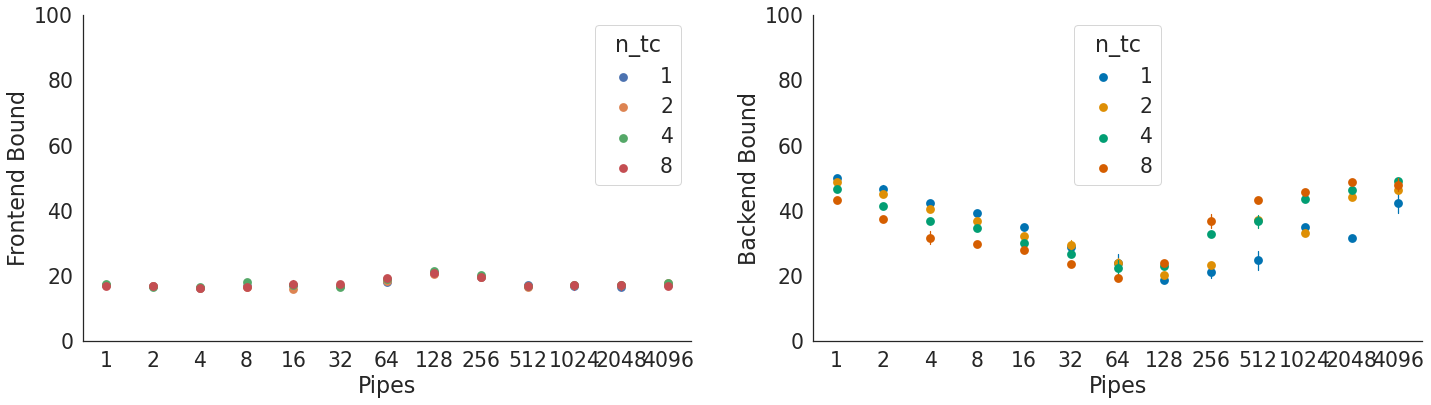

In [7]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[4*FIGSIZE[0], FIGSIZE[1]])

PKT_SIZE = 64

#ax1.set_xscale('symlog')

fig = sns.pointplot(
    data=shape_61_df,
    x="flows",
    y = 'Frontend Bound',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="n_tc",
    units="units",
    #estimator = None,
    ax=ax1,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=False,
    linestyle="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
   # ylabel="Total Rx (Mpps)",
    xlabel="Pipes",
   # title="Misses\nPkt size = 64 B",
    ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=shape_61_df,
    x="flows",
    y = 'Backend Bound',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="n_tc",
    units="units",
    #estimator = None,
    ax=ax2,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=False,
    linestyle="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    #ylabel="Total Rx (Mpps)",
    xlabel="Pipes",
    #title="Drops\nPkt size = 64 B",
    ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)


sns.despine()

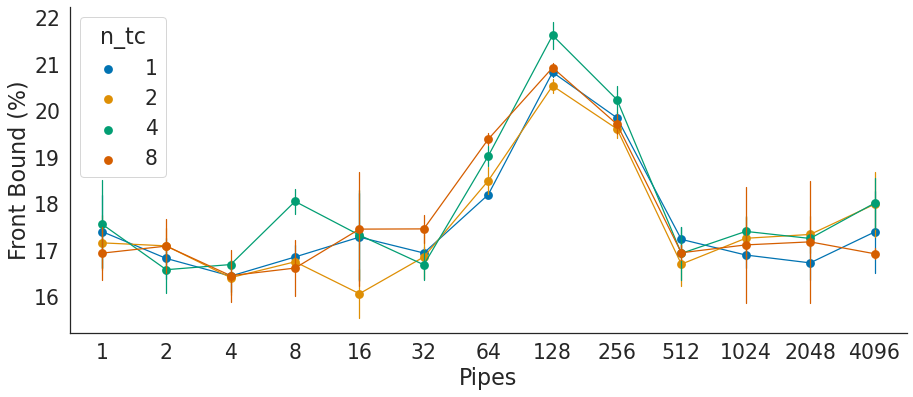

In [10]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[2.5*FIGSIZE[0], FIGSIZE[1]])

PKT_SIZE = 64

#ax1.set_xscale('symlog')

fig = sns.pointplot(
    data=shape_61_df,
    x="flows",
    y = 'Frontend Bound',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="n_tc",
    units="units",
    #estimator = None,
    ax=ax1,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=True,
    linestyle="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Front Bound (%)",
    xlabel="Pipes",
    #title="Drops\nPkt size = 64 B",
    #ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)


sns.despine()

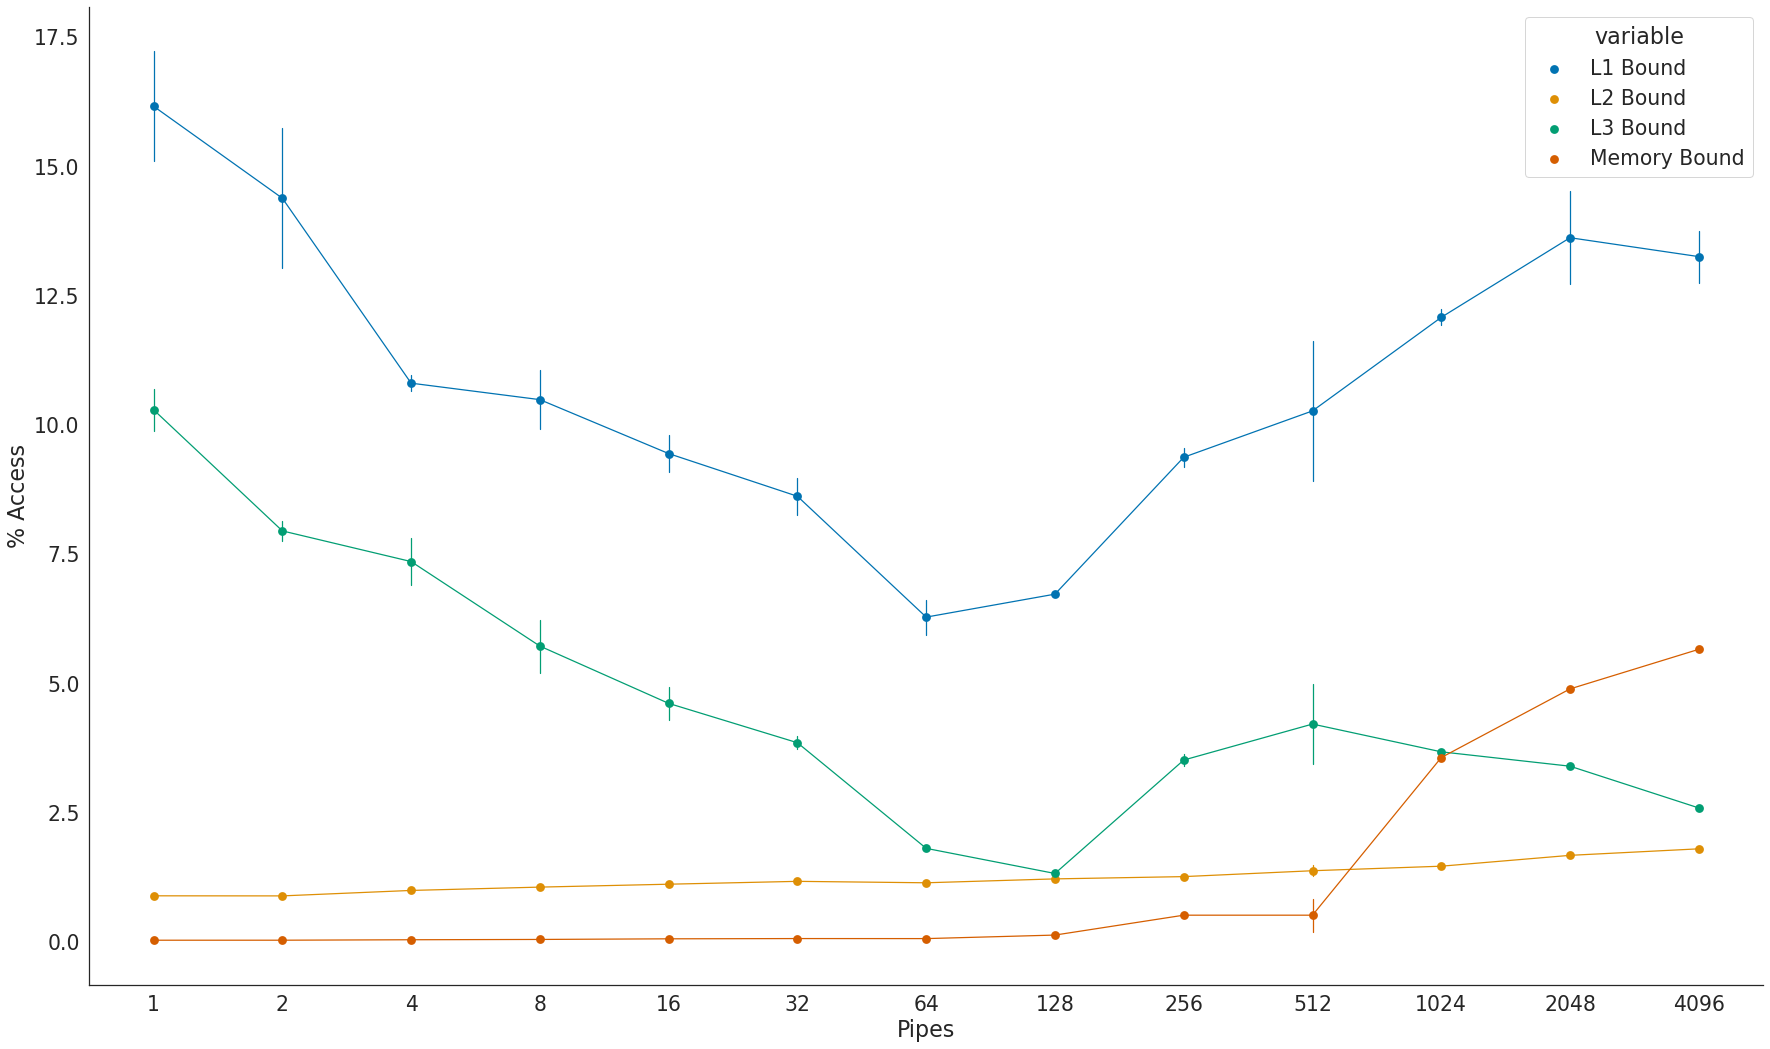

In [6]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[5*FIGSIZE[0], 3*FIGSIZE[1]])

PKT_SIZE = 64

p_df = pd.melt(
    shape_61_df,
    id_vars = ['flows', 'units', 'n_tc'],
    value_vars = ['L1 Bound','L2 Bound','L3 Bound','Memory Bound']
)

#ax1.set_xscale('symlog')
fig = sns.pointplot(
    data=p_df[p_df['n_tc'] == '4'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax1,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=True,
    linestyle="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="% Access",
    xlabel="Pipes",
   # title="Misses\nPkt size = 64 B",
   # ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

sns.despine()

### Multithreaded HQoS

In [87]:
measurements = list()
experiment_list = [
    "4flows-shaper",     
    "4flows-2th-shaper", 
]

for experiment in experiment_list:
    output_dir = f"../output/6.1-{experiment}"
    for direc, sub_direc, files in os.walk(output_dir):
        if "discarded" in direc:
            continue

        if files == []:
            continue

        if "old" in direc:
            continue

        t = dict()
        misses = 0
        drops = 0
        vectors = 0
        call = 0
        loops_p_worker = 0

        for file in files:
            none, flows, packet_size, repeat = direc.replace(output_dir, "").split("/")

            if "average" in file:
                perfstat = pd.read_csv(direc + "/" + file, index_col = 'metrics')

            if "vpp" in file:
                with open(
                    direc + "/" + file, "r", encoding="utf8", errors="ignore"
                ) as f:
                    for line in f.readlines():
                        p = line.strip().split()
                        if (
                            "/interfaces/dev0/rx-miss" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            misses = int(p[3])
                            continue

                        m = re.search(r"\[0 @ 2\]: (\d*) packets \/err\/dev1-tx\/Tx packet drops.*", line)
                        if (m):
                            drops += int(m.group(1))
                            continue

                        if (
                            "/sys/vector_rate_per_worker" in line
                            and "0]:" in p[2]
                            and "[2" in p[0]

                        ):
                            vectors = int(p[3])
                            continue
                        if "/sys/num_worker_threads" in p:
                            nworkers = float(p[0])



                        if (
                            " /sys/loops_per_worker" in line
                            and "0]:" in p[2]
                            and "[2" in p[0]
                        ):
                            loops_p_worker = int(p[3])
                            continue

            if "trex" in file:
                with open(direc + "/" + file, "r") as f:
                    contents = f.read().replace("\n", "").replace("'", '"')
                    try:
                        t = ast.literal_eval(contents)
                    except SyntaxError:
                        print(direc + "/" + files[0])
                        continue


        metric = 'max'
        total_errors = misses + drops
        pkt_loss = t["total"]["opackets"] - t["total"]["ipackets"]

        measurements.append(
            {
                "total_rx_L1": t["total"]["rx_bps_L1"],
                "total_tx_L1": int(t["total"]["tx_bps_L1"]),
                "total_tx_pps": int(t["total"]["tx_pps"]),
                "total_rx_pps": int(t["total"]["rx_pps"]),
                "lost_packets": pkt_loss,

                #"VNF": label,
                #'ST': 'SMT' if 'ht' in experiment else 'ST',
                'nworkers': int(nworkers),
                'n_tc': experiment.strip('flow-shaper'),
                "packet_size": int(packet_size),
                "misses": misses,
                'flows': int(flows),
                "drops": drops,
                "misses_normalized": misses
                / (1 if total_errors == 0 else total_errors)
                * 100,
                "drops_normalized": drops
                / (1 if total_errors == 0 else total_errors)
                * 100,
                #"no_buf": no_buf,
                "total_errors": total_errors,
                "units": repeat,
                "vectors": vectors,
                "loops": loops_p_worker,

                'IPC': perfstat.loc['metric_IPC', metric],
                'CPI': perfstat.loc['metric_CPI', metric],
                'Frontend Bound': perfstat.loc['metric_TMA_Frontend_Bound(%)',metric],
                'Backend Bound': perfstat.loc['metric_TMA_Backend_Bound(%)', metric],
                'Cache Bound': perfstat.loc['metric_TMA_..Memory_Bound(%)', metric],
                'Core Bound': perfstat.loc['metric_TMA_..Core_Bound(%)', metric],
                'Memory Bound': perfstat.loc['metric_TMA_....MEM_Bound(%)', metric],
                'DTLB load miss': perfstat.loc['metric_DTLB load miss latency (in core clks)', metric],
                
                'Ports Utilization': perfstat.loc['metric_TMA_......Ports_Utilized_3m(%)', metric],

                'L1 Bound': perfstat.loc['metric_TMA_....L1_Bound(%)', metric],
                'L2 Bound': perfstat.loc['metric_TMA_....L2_Bound(%)', metric],
                'L3 Bound': perfstat.loc['metric_TMA_....L3_Bound(%)',metric],

              #"vector_rate": vector_rate,
            }
        )
        mt_df = pd.DataFrame(measurements)

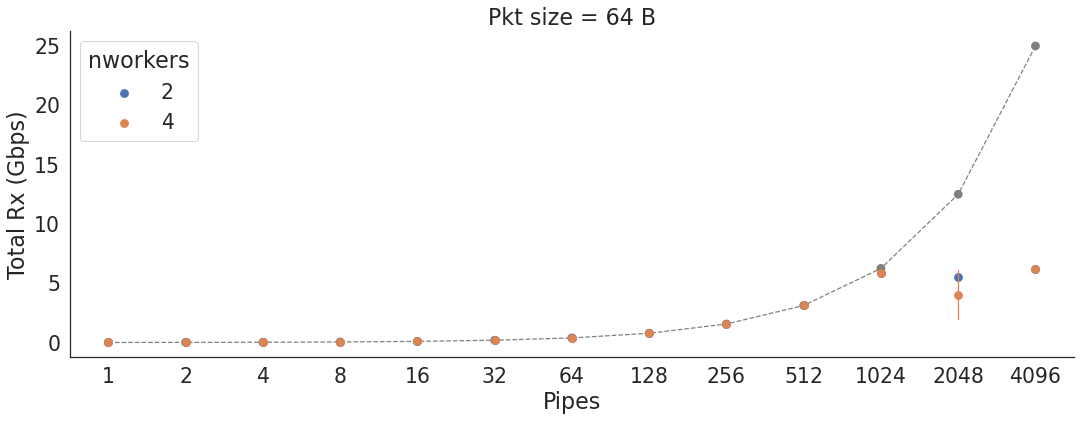

In [88]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[3*FIGSIZE[0], FIGSIZE[1]])

PKT_SIZE = 64

ideal_rate_df = pd.DataFrame([(i, 6.1*i) for i in set(shape_61_df['flows'])])

fig = sns.pointplot(
    data=ideal_rate_df,
    x=0,
    y = ideal_rate_df[1]/(10**3),
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    #estimator = None,
    ax=ax1,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=True,
    linestyle="--",
    linewidth=0.005,
    color = 'grey',
    linestyles="--",
    # hue_order = [64, 256, 512, 1500],
)


fig = sns.pointplot(
    data=mt_df,
    x="flows",
    y = mt_df['total_rx_L1']/(10**9),
    #y=shape_61_df["total_rx_pps"] / (10**6),
    hue="nworkers",
    units="units",
    #estimator = None,
    ax=ax1,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=False,
    linestyle="--",
    linewidth=0.005,
    
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Total Rx (Gbps)",
    xlabel="Pipes",
    title="Pkt size = 64 B",
)
plt.setp(fig.lines, linewidth=1.25)
sns.despine()

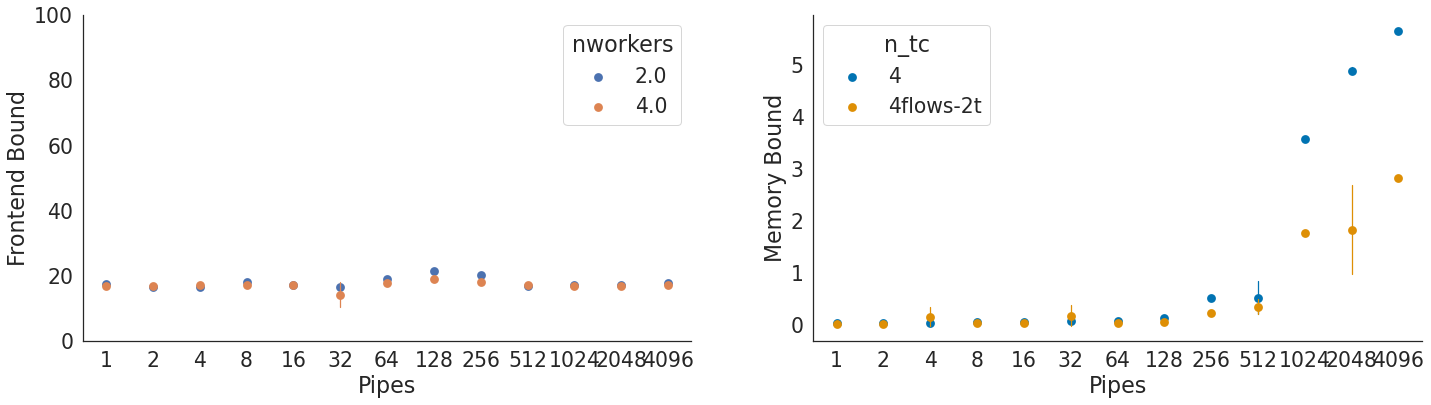

In [73]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[4*FIGSIZE[0], FIGSIZE[1]])

PKT_SIZE = 64

#ax1.set_xscale('symlog')

fig = sns.pointplot(
    data=mt_df,
    x="flows",
    y = 'Frontend Bound',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="nworkers",
    units="units",
    #estimator = None,
    ax=ax1,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=False,
    linestyle="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
   # ylabel="Total Rx (Mpps)",
    xlabel="Pipes",
   # title="Misses\nPkt size = 64 B",
    ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=mt_df,
    x="flows",
    y = 'Memory Bound',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="n_tc",
    units="units",
    #estimator = None,
    ax=ax2,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=False,
    linestyle="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    #ylabel="Total Rx (Mpps)",
    xlabel="Pipes",
    #title="Drops\nPkt size = 64 B",
    #ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)


sns.despine()

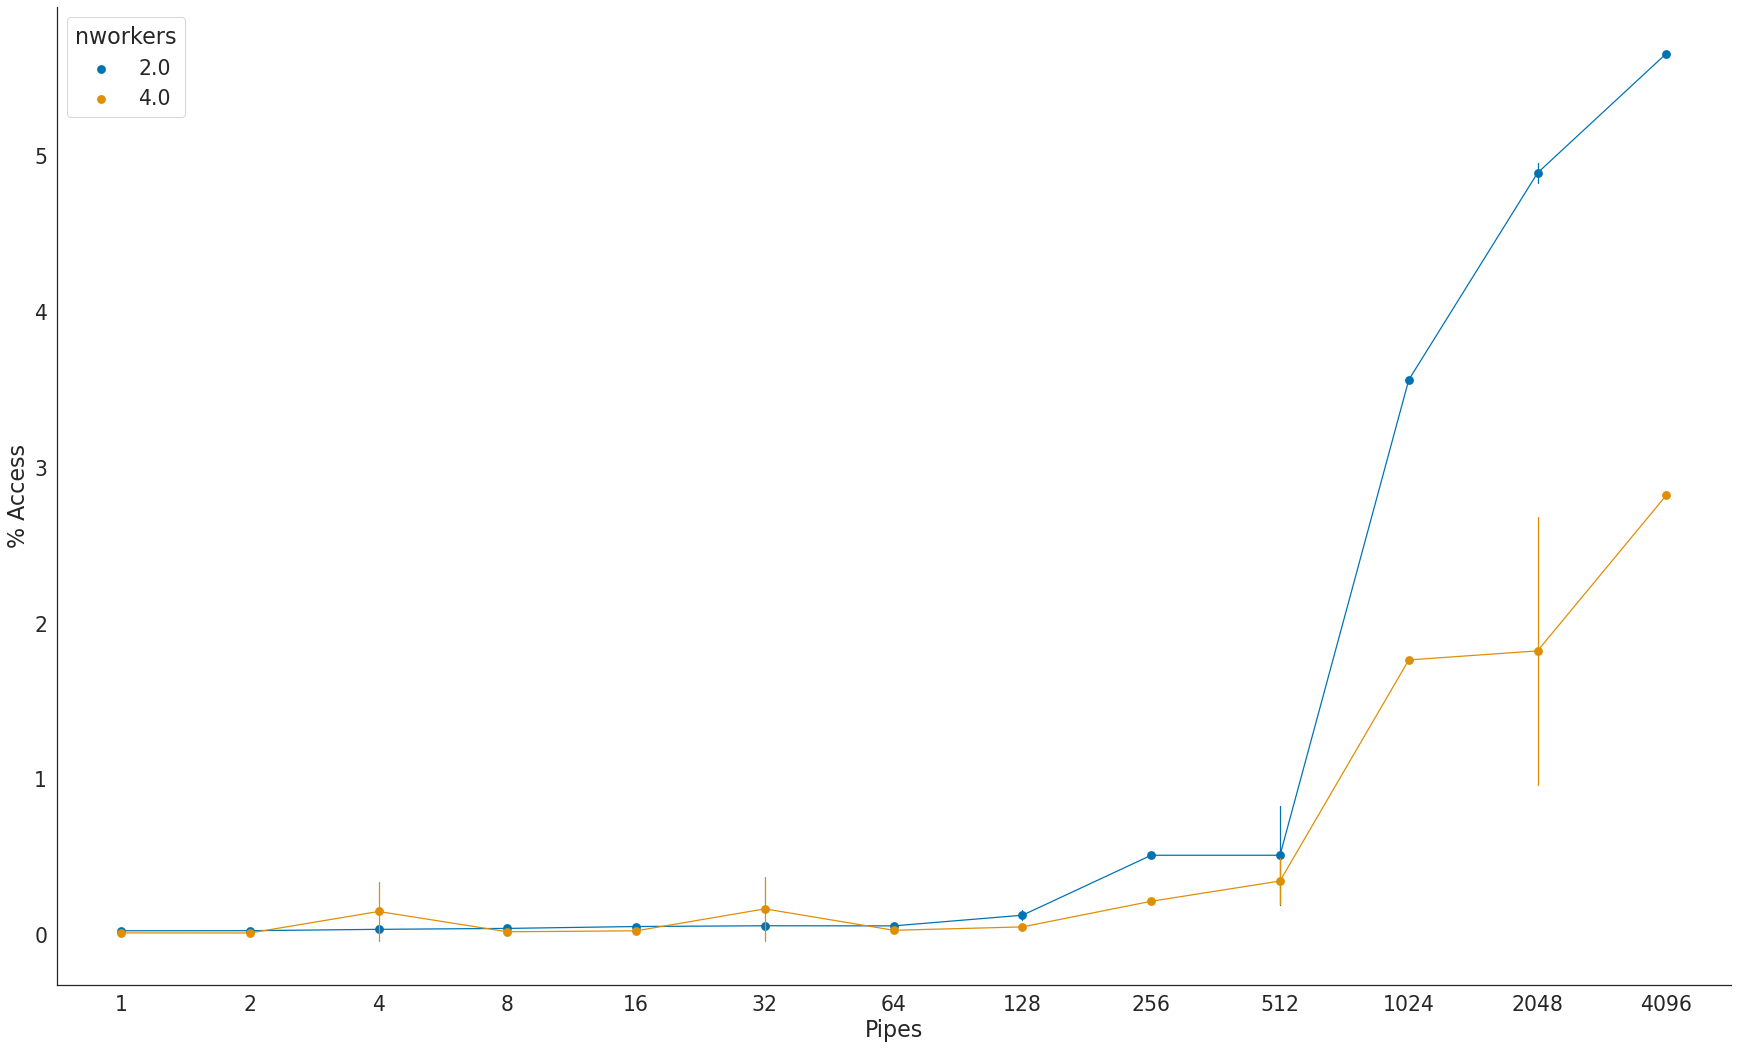

In [86]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[5*FIGSIZE[0], 3*FIGSIZE[1]])

PKT_SIZE = 64

p_df = pd.melt(
    mt_df,
    id_vars = ['flows', 'units', 'nworkers'],
    #value_vars = ['L1 Bound','L2 Bound','L3 Bound','Memory Bound'],
    value_vars = ['Memory Bound']
)

#ax1.set_xscale('symlog')
fig = sns.pointplot(
    data=p_df,
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="nworkers",
    units="units",
    style = 'nworkers',
    #estimator = None,
    ax=ax1,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="% Access",
    xlabel="Pipes",
   # title="Misses\nPkt size = 64 B",
   # ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

sns.despine()

# Setup

We testing VPP at commit 2b5bc3bce6fc5d4a2bbe1342522c62f9da0efd19.

Grub cmdline parameters

```
ST: GRUB_CMDLINE_LINUX_DEFAULT="crashkernel=auto isolcpus=8-27,29-55 iommu=pt intel_iommu=on default_hugepagesz=1G hugepagesz=1G hugepages=32 nohz_full=8-27,29-55 tsc=reliable irqaffinity=0 rcu_nocbs=8-27,29-55 rcu_nocbs_poll idle=poll rsc=reliable mce=ignore_ce audit=0 nmi_watchdog=0 skew_tick=1 nosoftlookup nosmt"
SMT: GRUB_CMDLINE_LINUX_DEFAULT="crashkernel=auto isolcpus=8-27,64-83,29-55,85-111 iommu=pt intel_iommu=on default_hugepagesz=1G hugepagesz=1G hugepages=32 nohz_full=8-27,64-83,29-55,85-111 tsc=reliable irqaffinity=0 rcu_nocbs=8-27,64-83,29-55,85-111 rcu_nocbs_poll idle=poll rsc=reliable mce=ignore_ce audit=0 nmi_watchdog=0 skew_tick=1 nosoftlookup" 
```

```
4: enp134s0f0: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc mq state UP mode DEFAULT group default qlen 1000
    link/ether 40:a6:b7:0a:7f:18 brd ff:ff:ff:ff:ff:ff
    vf 0     link/ether 00:00:00:01:00:01 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 1     link/ether 00:00:00:01:00:02 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 2     link/ether c6:84:89:9d:96:e2 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 3     link/ether 82:a8:ee:9f:fa:78 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 4     link/ether 56:d7:48:ab:28:4d brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 5     link/ether 96:51:14:d4:e7:93 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 6     link/ether 12:c9:27:fb:39:45 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 7     link/ether f2:a8:44:71:f4:3c brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 8     link/ether c6:71:cc:d3:ec:d4 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 9     link/ether a2:0f:d6:44:a7:79 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 10     link/ether 1a:b1:54:53:9a:4b brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 11     link/ether 6a:3c:1b:ad:1b:be brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 12     link/ether da:90:04:23:eb:78 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
5: enp134s0f1: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc mq state UP mode DEFAULT group default qlen 1000
    link/ether 40:a6:b7:0a:7f:19 brd ff:ff:ff:ff:ff:ff                                                                 
    vf 0     link/ether a6:b2:8b:f7:38:80 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 1     link/ether 6e:bd:8b:a0:c3:be brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 2     link/ether c6:6f:b7:15:e3:2f brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 3     link/ether 1e:90:a4:db:9c:73 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 4     link/ether e2:a0:b8:aa:6a:8e brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 5     link/ether be:31:2d:e5:d0:f8 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 6     link/ether b6:2c:04:8d:9e:3c brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 7     link/ether 4e:69:cc:9e:07:23 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 8     link/ether 52:a5:32:0f:b5:d7 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 9     link/ether d6:54:bd:02:4f:f3 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 10     link/ether 92:b3:64:66:db:b4 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 11     link/ether 42:8a:fd:a9:1e:12 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 12     link/ether 56:e4:5e:e2:6d:dd brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
```

```
unix {
  nodaemon
  interactive
  log /var/log/vpp.log
  full-coredump
  cli-listen /run/vpp/cli.sock
  # cli-listen 0.0.0.0:5002
  exec /etc/vpp/vpp_cli.conf.l2xc
}

api-trace {
  on
}

statseg {
  size 1G
}

socksvr {
  socket-name /run/vpp/api.sock
}

plugins {
  plugin default { disable }
  plugin dpdk_plugin.so { enable }
}

cpu {
  main-core 44
  corelist-workers 36
  # corelist-hqos-threads 37
}

memory {
  main-heap-size 500M
  main-heap-page-size 1G
}

dpdk {
  no-multi-seg
  no-tx-checksum-offload

  dev default {
    num-rx-desc 4096
    num-tx-desc 4096
    num-rx-queues 1
  }
  dev 0000:86:01.0 {
    name dev0
  }
  dev 0000:86:01.1 {
    name dev1
    # hqos {}
  }
}

logging {
  ## Available severity levels:
  ## emerg|alertcrit|err|warn|notice|info|debug|disabled

  default-log-level info
  default-syslog-log-level info
}

buffers {
   buffers-per-numa 256000
   default data-size 2048
   page-size default-hugepage
}

# statseg {
#    per-node-counters on
#  }
```

```
set int mac address dev0 00:00:00:01:00:01
set int mac address dev1 00:00:00:01:00:02
# set int mac address dev2 00:00:00:01:00:02
# set int mac address dev3 00:00:00:01:00:03
# set int mac address dev4 00:00:00:01:00:04
# set int mac address dev5 00:00:00:01:00:05
# set int mac address dev6 00:00:00:01:00:06
# set int mac address dev7 00:00:00:01:00:07
# set int mac address dev8 00:00:00:01:00:08
# set int mac address dev9 00:00:00:01:00:09
# set int mac address dev10 00:00:00:01:00:10
# set int mac address dev11 00:00:00:01:00:11

set interface l2 xconnect dev0 dev1
set interface l2 xconnect dev1 dev0

# set interface l2 xconnect dev2 dev3
# set interface l2 xconnect dev3 dev2

# set interface l2 xconnect dev4 dev5
# set interface l2 xconnect dev5 dev4

# set interface l2 xconnect dev6 dev7
# set interface l2 xconnect dev7 dev6

# set interface l2 xconnect dev8 dev9
# set interface l2 xconnect dev9 dev8
# 
# set interface l2 xconnect dev10 dev11
# set interface l2 xconnect dev11 dev10

set interface promiscuous off dev1
# set interface promiscuous off dev3
# set interface promiscuous off dev5
# set interface promiscuous off dev7
# set interface promiscuous off dev9
# set interface promiscuous off dev11

set interface state dev0 up
set interface state dev1 up
# set interface state dev2 up
# set interface state dev3 up
# set interface state dev4 up
# set interface state dev5 up
# set interface state dev6 up
# set interface state dev7 up
# set interface state dev8 up
# set interface state dev9 up
# set interface state dev10 up
# set interface state dev11 up

set interface rx-placement dev0 worker 0
set interface rx-placement dev1 worker 0
# set interface rx-placement dev2 worker 1
# set interface rx-placement dev3 worker 1
# set interface rx-placement dev4 worker 2
# set interface rx-placement dev5 worker 2
# set interface rx-placement dev6 worker 3
# set interface rx-placement dev7 worker 3
# set interface rx-placement dev8 worker 4
# set interface rx-placement dev9 worker 4
# set interface rx-placement dev10 worker 5
# set interface rx-placement dev11 worker 5

```